## Polar Coordinate System

### Safe Set Generation

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString,Point,LinearRing
from shapely.ops import unary_union

from matplotlib.patches import Polygon
from cvxopt import matrix, solvers
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

In [5]:
class SafeSet:
    # Everytime update_safe_set is called, the object stores an attribute called best_safe_set_config
    def __init__(self, robot_config, algo_config):
        
        self.theta_min  = robot_config['theta_min']
        self.theta_max  = robot_config['theta_max']
        self.max_depth  = robot_config['max_depth']
        self.min_depth  = robot_config['min_depth']
        self.r_limit    = robot_config['r_limit']
        self.r0         = robot_config['r0']

        self.step_index = 100
        # self.resolution= robot_config['resolution']

        self.fov = self.theta_max - self.theta_min

        # self.radial_distances = [self.min_depth for i in range(self.resolution)]
        # self.theta_axis = np.linspace(self.theta_max,self.theta_min,len(self.radial_distances),endpoint=False)

        self.radial_distances = None
        self.theta_axis = None
        self.reference_direction = 0 # Default

        self.best_safe_set_config = {}

        self.k_depth = algo_config['k_depth']
        self.k_angular = algo_config['k_angular']
        self.k_deviation = algo_config['k_deviation']
        self.metric_type = algo_config['metric_type']

        self.feasible_safe_sets_percent = None

    def update_reference_direction(self,reference_direction):
        '''Updates the Reference Direction whenever required'''
        self.reference_direction = reference_direction

    def update_safe_set(self, radial_distances):
        '''Updates the Best Safe Set as new depth data comes in'''
        self.radial_distances = radial_distances
        self.theta_axis = np.linspace(self.theta_max,self.theta_min,len(self.radial_distances),endpoint=False)

        depth_points = np.hstack([self.theta_axis.reshape(-1,1),self.radial_distances.reshape(-1,1)])
        
        left_extreme_robot, right_extreme_robot = self.get_left_right_extremes()

        depth_points_cartesian = self.get_depth_points_cartesian(left_extreme_robot,right_extreme_robot)
        depth_line_s = LineString(depth_points_cartesian)

        c = 0 # Counts the Number of Feasible Safe Sets
        t = 0 # Counts the Total Number of Safe Sets
        best_safe_set_metric=0
        for i in range(0,len(self.radial_distances),self.step_index):
            for j in range(i+1, len(self.radial_distances),self.step_index):
                
                t+=1
                r_min = depth_points[i:j,1].min()  # 1 represents index for radial distance!
                theta1 = depth_points[j,0]
                theta2 = depth_points[i,0]
                
                left_robot_point, right_robot_point = self.get_robot_points(theta1=theta1,theta2=theta2,rs=r_min)

                if left_robot_point[0]-right_robot_point[0]<np.pi: #Checking if the safe set is too narrow
                    continue

                left_depth_point = (theta2,r_min)
                right_depth_point = (theta1,r_min)
                safe_set_points = np.array([left_depth_point,left_robot_point,right_robot_point,right_depth_point,left_depth_point])

                safe_set_points_cartesian = self.get_safe_set_points_cartesian(safe_set_points)

                # Checking if the safe set intersects with the depth line
                safe_set_points_s = LinearRing(safe_set_points_cartesian)
                intersection_obj = depth_line_s.intersection(safe_set_points_s)
                if intersection_obj.is_empty:
                    c+=1
                    deviation_component = abs(np.pi/2+self.reference_direction-(theta1+theta2)/2)/self.fov
                    angular_component = (theta2-theta1)/self.fov

                    if self.metric_type == 'sum':
                        safe_set_metric = self.k_depth*r_min/self.max_depth + self.k_angular*angular_component + self.k_deviation*deviation_component
                    elif self.metric_type == 'product':
                        safe_set_metric = r_min*angular_component/deviation_component
                    else:
                        raise

                    if safe_set_metric>best_safe_set_metric:
                        best_safe_set_metric=safe_set_metric
                        self.best_safe_set_config['i']=i
                        self.best_safe_set_config['j']=j
                        self.best_safe_set_config['theta1'] = theta1
                        self.best_safe_set_config['theta2'] = theta2
                        self.best_safe_set_config['r_min'] = r_min
                        self.best_safe_set_config['Metric'] = safe_set_metric
                        self.best_safe_set_config['left_robot_point'] = left_robot_point
                        self.best_safe_set_config['right_robot_point'] = right_robot_point
                        self.best_safe_set_config['left_depth_point'] = left_depth_point
                        self.best_safe_set_config['right_depth_point'] = right_depth_point

                        phi = np.arccos(self.r0/r_min)

                        t1 = theta1+np.pi/2-phi
                        t2 = theta2-np.pi/2+phi

                        self.best_safe_set_config['Shrunk_theta1'] = t1
                        self.best_safe_set_config['Shrunk_theta2'] = t2
                        self.best_safe_set_config['Shrunk_depth'] = r_min-self.r0


                
        self.feasible_safe_sets_percent = (c/t)*100

    ########## HELPER FUNCTIONS FOR update_safe_set ##########
    def get_left_right_extremes(self):
        '''
        Returns the left and right tangent points in Polar Coordinates on the robot for theta_min and theta_max
        '''

        right_extreme_depth = (self.theta_min,self.radial_distances[-1])
        _,right_extreme_robot = self.get_tangent_coordinates(right_extreme_depth[0],right_extreme_depth[1],self.r0)

        left_extreme_depth = (self.theta_max,self.radial_distances[0]) #Left Extreme point of the Depth Line (Blue) in Polar Coordinates
        left_extreme_robot,_ = self.get_tangent_coordinates(left_extreme_depth[0],left_extreme_depth[1],self.r0)

        return left_extreme_robot,right_extreme_robot  
    

    def get_cartesian(self,polar_coords):
        '''
        polar_coords: A tuple
        '''
        theta,r = polar_coords
        return r*np.cos(theta),r*np.sin(theta)
    
    def get_safe_set_points_cartesian(self,safe_set_points,shrinking_factor=0.99):
        '''
        Used to form the linear ring to check intersection with depth line
        '''
        safe_set_points_cartesian = np.hstack([shrinking_factor*safe_set_points[:,1:2]*np.cos(safe_set_points[:,0:1]),shrinking_factor*safe_set_points[:,1:2]*np.sin(safe_set_points[:,0:1])])
        return safe_set_points_cartesian
    
    def get_depth_points_cartesian(self,left_extreme_robot,right_extreme_robot):
        '''
        Used to build the depth_line
        '''
        x_axis_points = (self.radial_distances*np.cos(self.theta_axis)).reshape(-1,1)
        y_axis_points = (self.radial_distances*np.sin(self.theta_axis)).reshape(-1,1)

        left_extreme_robot_cartesian = self.get_cartesian(left_extreme_robot)
        right_extreme_robot_cartesian = self.get_cartesian(right_extreme_robot)

        x_axis_points[0,0] = left_extreme_robot_cartesian[0]
        y_axis_points[0,0] = left_extreme_robot_cartesian[1]

        x_axis_points[-1,0] = right_extreme_robot_cartesian[0]
        y_axis_points[-1,0] = right_extreme_robot_cartesian[1]

        return np.hstack([x_axis_points,y_axis_points]) 

    def get_tangent_coordinates(self,theta,d,r0):
        '''
        d,theta: Polar Coordinates of the point
        r0: Radius of the Robot

        Returns the 2 Points of Intersections of the tangents from a point to a circle
        '''
        if d<=r0:
            print(d)
            raise
        phi = np.arccos(r0/d)
        

        assert 0<phi<np.pi/2,"Phi: {:.2f},r0: {:.2f},d: {:.2f}".format(phi*180/np.pi,r0,d)

        left_point = (theta+phi,r0)
        right_point = (theta-phi,r0)
        points = [left_point,right_point]
        return points

    def get_robot_points(self,theta1,theta2,rs):
        '''
        theta1: Angular Distance of Right Point, lower angle wrt x-axis
        theta2: Angular Distance of Left Point, higher angle wrt x-axis
        rs: Min Radial Distance in (theta1,theta2)
        Returns the two points on the Robot
        '''
            
        _,right_robot_point = self.get_tangent_coordinates(theta1,rs,self.r0)
        left_robot_point,_ = self.get_tangent_coordinates(theta2,rs,self.r0)

        return left_robot_point,right_robot_point 

    ############# FUNCTIONS USED FOR VISUALISATION ##########
    def render(self,only_depth_line=False):
        '''
        Returns the ax object populated with depth_line and end tangents
        '''
        # desired_dpi = 80  # Adjust the DPI to your desired resolution
        # fig = plt.figure(dpi=desired_dpi)
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(polar=True)
        # Plots the Depth Line
        ax.plot(self.theta_axis,self.radial_distances)

        # Plot radial lines
        # ax.plot([theta_min, theta_min], [0, 2.5], color='r', linestyle='-', linewidth=2, label='Theta 1')
        # ax.plot([theta_max, theta_max], [0, 2.5], color='r', linestyle='-', linewidth=2, label='Theta 2')

        # Plots the Robot as a Filled Circle
        theta_robot_fill = np.linspace(0, 2 * np.pi, 100)  # Create 100 points around the circumference
        r = np.full_like(theta_robot_fill, self.r0)  # Set the radius for all points
        # print(r)

        # Plot the circle
        ax.fill(theta_robot_fill, r, color='green')

        # Plotting Extreme Left and Right Tangents
        #Left Extreme Tangent
        left_extreme_depth = (self.theta_max,self.radial_distances[0]) #Left Extreme point of the Depth Line (Blue) in Polar Coordinates
        left_extreme_robot,_ = self.get_tangent_coordinates(left_extreme_depth[0],left_extreme_depth[1],self.r0)
        ax.plot([left_extreme_depth[0],left_extreme_robot[0]],[left_extreme_depth[1],left_extreme_robot[1]],color='r')

        #Right Extreme Tangent
        right_extreme_depth = (self.theta_min,self.radial_distances[-1])
        _,right_extreme_robot = self.get_tangent_coordinates(right_extreme_depth[0],right_extreme_depth[1],self.r0)
        ax.plot([right_extreme_depth[0],right_extreme_robot[0]],[right_extreme_depth[1],right_extreme_robot[1]],color='r')

        #Setting Limits
        # ax.set_thetamin((theta_min-np.pi/2)*180/np.pi)
        # ax.set_thetamax((theta_max+np.pi/2)*180/np.pi)
        ax.set_thetamin(0)
        ax.set_thetamax(180)
        ax.set_rmax(self.r_limit)

        # if only_depth_line:
        #     pass 
        # else:
        left_robot_point = self.best_safe_set_config['left_robot_point']
        right_robot_point = self.best_safe_set_config['right_robot_point']
        left_depth_point = self.best_safe_set_config['left_depth_point']
        right_depth_point = self.best_safe_set_config['right_depth_point']

        safe_set_points = np.array([left_depth_point,left_robot_point,right_robot_point,right_depth_point,left_depth_point])
        ax.scatter(safe_set_points[:,0],safe_set_points[:,1],c='g',linewidths=1)
        ax.plot(safe_set_points[:,0],safe_set_points[:,1],c='g')


        # Shrinking the Safe Set by Robot Radius

        t1 = self.best_safe_set_config['Shrunk_theta1']
        t2 = self.best_safe_set_config['Shrunk_theta2']
        r_shrunk = self.best_safe_set_config['Shrunk_depth']
        ax.plot([0,t1,t2,0],[0,r_shrunk,r_shrunk,0])
        

        fig.canvas.draw()

        data0 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        # print(data0.shape)
        # print(fig.canvas.get_width_height())
        data = data0.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        self.rendered_data = data

def get_slice(depth_img,row_frac):
    '''Returns the list of depths taken at the slice of the depth image'''
    h,w = depth_img.shape
    slice = depth_img[int(h*row_frac),:]

    return slice

def get_sliced_img(img,row_frac):
    '''Returns an RGB image with a red line indicating the where the depth slice is taken from'''
    slice_thickness = 0.01

    h,_,_ = img.shape
    row = int(row_frac*h)

    img_sliced = img.copy()
    img_sliced[row-int(slice_thickness*h):row+int(slice_thickness*h),:] = [255,0,0]

    return img_sliced

In [6]:
#Read the Images
depth_img = np.load('../Data_Files/Larger Safe Set/FirstFrame_Depth.npy')
rgb_img = np.load('../Data_Files/Larger Safe Set/FirstFrame_RGB.npy')


robot_config = {'theta_min':2*np.pi/6, # Minimum Angle of the Camera
                'theta_max':4*np.pi/6, # Maximum Angle of the Camera
                'max_depth':2.5, # Maximum Depth Perceived by the Camera (Used in the Loss Function)
                'min_depth':0.2, # Minimum Depth Perceived by the Camera
                'r_limit'  :2.5, # Maximum Radial Distance to Depict in the Plots
                'r0'       :0.15, # Robot Radius 
                'l'        :-0.08, #Distance of axle from Centre
                # 'resolution': 1920
                }

algo_config = {'k_depth':3,'k_angular':1,'k_deviation':-1,'metric_type':'sum'}

slice_height = 0.6
rgb_img_switched = rgb_img[..., ::-1]
rgb_img_slice = get_sliced_img(rgb_img_switched,slice_height) #RGB image with slice

depth_1d = (get_slice(depth_img,slice_height))
depth_1d = np.nan_to_num(depth_1d, nan=robot_config['min_depth'])

/var/folders/pw/pb93h1ws5dx02zs9x_45hk4w0000gn/T/ipykernel_60830/273272473.py:257: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  data0 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


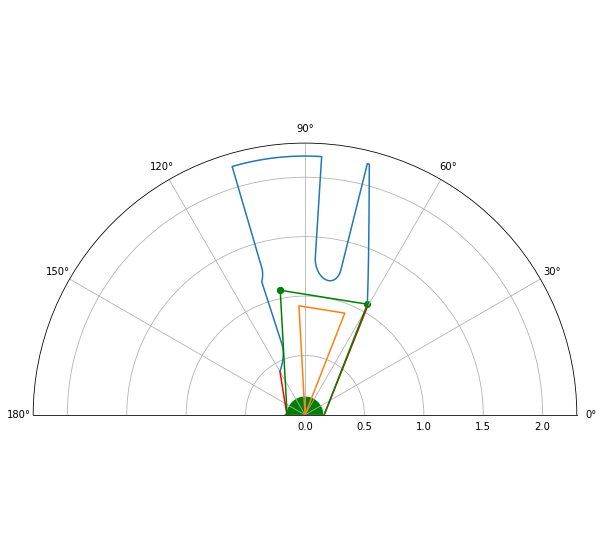

In [7]:
safeset = SafeSet(robot_config,algo_config)
safeset.update_safe_set(depth_1d)

if safeset.feasible_safe_sets_percent>0:
    data = safeset.render(only_depth_line=False)

else:
    data = safeset.render(only_depth_line=False)
    print("No Safe Set Found")

In [8]:
depth_1d[:1600]=0.21

In [9]:
safeset.best_safe_set_config

{'i': 600,
 'j': 1901,
 'theta1': 1.0575604436303139,
 'theta2': 1.7671458676442584,
 'r_min': 1.0694273710250854,
 'Metric': 1.8096149285634355,
 'left_robot_point': (3.197216189501783, 0.15),
 'right_robot_point': (-0.3725098782272107, 0.15),
 'left_depth_point': (1.7671458676442584, 1.0694273710250854),
 'right_depth_point': (1.0575604436303139, 1.0694273710250854),
 'Shrunk_theta1': 1.1982864485676858,
 'Shrunk_theta2': 1.6264198627068864,
 'Shrunk_depth': 0.9194273710250854}

In [10]:
t1 = safeset.best_safe_set_config['Shrunk_theta1']*180/np.pi
t2 = safeset.best_safe_set_config['Shrunk_theta2']*180/np.pi

print("t1: {:.2f},  t2: {:.2f}".format(t1,t2))

t1: 68.66,  t2: 93.19


(0.0, 2.5)

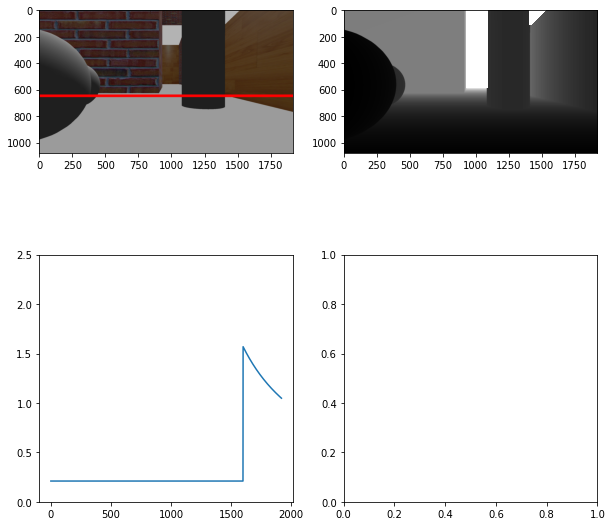

In [11]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
axs[0][0].imshow(rgb_img_slice)

axs[0][1].imshow(depth_img,cmap='gray')

axs[1][0].plot(depth_1d)
axs[1][0].set_ylim(0,robot_config['r_limit'])

### Control Synthesis (New Code)


#### Control Synthesis Class


In [15]:
class Controller:
    def __init__(self,robot_config, algo_config):
        # rospy.Subscriber('/odom',Odometry,self.odom_callback)

        self.theta_min  = robot_config['theta_min']
        self.theta_max  = robot_config['theta_max']
        self.max_depth  = robot_config['max_depth']
        self.min_depth  = robot_config['min_depth']
        self.r_limit    = robot_config['r_limit']
        self.r0         = robot_config['r0']
        self.l          = robot_config['l']

        # Algo Related
        self.gamma      = algo_config['gamma']
        self.Q          = np.array([[algo_config['Q_u1'],0],[0,1]]).astype(np.float64)
        self.u1_limit   = algo_config['u1_limit']  # Upper Bound of Linear Velocity
        self.u2_limit   = algo_config['u2_limit']  # Upper Bound for the Angular Velocity
        self.k          = algo_config['k']  # Reference Angular Velocity = -k*theta
        self.u1_ref     = algo_config['u1_ref']  # Forward Velocity Reference

        self.X_global   = None  # Global Coordinates of the Bot from /odom
        self.safeset    = {'t1':None,'t2':None,'depth':None,'origin':None} # Safeset Configuration

        # rospy.Subscriber('/safe_set_config',SafeSetConfig,update_safeset_callback)

    def odom_callback(self,data):
        '''
        Callback function for /odom topic subscription
        Updates the state of the robot: (x,y,theta,linear_velocity,angular_velocity)
        '''
        pose = data.pose.pose
        linear_velocity = data.twist.twist.linear
        angular_velocity = data.twist.twist.angular

        quaternion = [pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w]
        # Convert the quaternion to a rotation matrix
        rotation_matrix = tf.transformations.quaternion_matrix(quaternion)

        # Extract the yaw angle (rotation about Z-axis)
        assert self.l<0 # Remove the 180 degree
        yaw = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])*180/np.pi + 180 #Adding the 180 brings the range to [-180,180]

        self.robot_state = [pose.position.x,pose.position.y,yaw,linear_velocity.x,linear_velocity.z]
        
        print("(x, y, theta): {:.2f}, {:.2f}, {:.2f}, (u,w): {:.2f},{:.2f}".format(pose.position.x, pose.position.y, yaw,linear_velocity.x,angular_velocity.z))

    def update_safeset_callback(self,data):
        '''
        Callback function for /safe_set_config topic
        Updates the safeset parameters 
        '''
        self.safeset['t1']      = data.t1
        self.safeset['t2']      = data.t2
        self.safeset['depth']   = data.depth

        self.safeset['origin'] = self.robot_state # The safeset origin in global coordinate system


    ######## HELPER FUNCTIONS TO SYNTHESIS THE CONTROL ##########
    def get_Xp(self,Xc,l):
        '''
        Returns the coordinates of the Axle from centre coordinates in SafeSet Coordinate System
        '''
        xp = Xc[0]+l*np.cos(Xc[2])
        yp = Xc[1]+l*np.sin(Xc[2])
        thetap = Xc[2]

        Xp = np.array([xp,yp,thetap])
        return Xp

    def h_val(self,theta_set_i,X,l):
        '''
        Helper Function to write the functions as given in FORMULATION 2 (2) in NOTES
        '''
        x = X[0][0]
        y = X[1][0]
        theta = X[2][0]
        return -np.tan(theta_set_i)*x + y - l*np.sin(theta) + l*np.tan(theta_set_i)*np.cos(theta)


    def get_G_h_opt(self,X,U_ref):
        '''
        Returns G and h which specify the inequalities for the CBF in the optimisation problem 
        Assumes Safe Set Coordinate System
        '''
    
        gamma = self.gamma
        l = self.l
        t1 = self.safeset['t1']
        t2 = self.safeset['t2']
        depth = self.safeset['depth']

        u1_limit = self.u1_limit
        u2_limit = self.u2_limit
        theta = X[2][0] #extracting theta for easier usage in later formulae

        #if either t1 or t2 is a 90 degree angle
        if t1==np.pi/2:
            t1 = t1 - 0.1*np.pi/180 #Nudging t1 by 0.1 degree if it is 90 degrees
        if t2==np.pi/2:
            t2 = t2 + 0.1*np.pi/180

        # Finding a1,a2,a3 depending on theta and safe set config (NOTE: these a_i's are different from that implemented below, look at written notes)
        if 0<=t1<np.pi/2:
            a1 = np.array([-np.tan(t1),1,-(l*np.cos(theta)+l*np.sin(theta)*np.tan(t1))])
            h1 = self.h_val(t1,X,l)

        elif np.pi/2<t1<=np.pi:
            a1 = -np.array([-np.tan(t1),1,-(l*np.cos(theta)+l*np.sin(theta)*np.tan(t1))])
            h1 = -self.h_val(t1,X,l)

        if 0<=t2<np.pi/2:
            a2 = np.array([np.tan(t2),-1,l*np.cos(theta)+l*np.sin(theta)*np.tan(t2)])
            h2 = -self.h_val(t2,X,l)

        elif np.pi/2<t2<=np.pi:
            a2 = -np.array([np.tan(t2),-1,l*np.cos(theta)+l*np.sin(theta)*np.tan(t2)])
            h2 = self.h_val(t2,X,l)


        a3 = np.array([0,-1,l*np.cos(theta)])
        h3 = -X[1][0]+l*np.sin(theta)+depth

        # From system dynamics: x_dot = Ax + Bu
        B = np.array([[np.cos(theta),0],[np.sin(theta),0],[0,1]])

        G_opt = -np.vstack([a1@B,a2@B,a3@B,np.array([-1,0]),np.array([0,-1])])
        h_opt = np.vstack([gamma*h1+a1@B@U_ref,gamma*h2+a2@B@U_ref,gamma*h3+a3@B@U_ref,np.array([u1_limit-U_ref[0][0]]),np.array([u2_limit-U_ref[1][0]])])

        assert h1>=0, 'h1 = {}'.format(h1)
        assert h2>=0, 'h2 = {}'.format(h2)
        assert h3>=0, 'h3 = {}, h3 = {:.2f} + {:.2f} + {:.2f}'.format(h3,-X[1][0],l*np.sin(theta),depth)
        
        info = {'a1':a1,'a2':a2,'a3':a3,'G_opt':G_opt,'h_opt':h_opt,'B_model':B}

        return G_opt,h_opt,info

    def get_U(X,U_ref):
        '''
        U is synthesised by solving the optimisation problem
        Assumes Safe Set Coordinate System
        '''
        
        depth = self.safeset['depth']
        gamma = self.gamma
        Q = self.Q

        G_opt, h_opt,info = self.get_G_h_opt(X,gamma,U_ref)

        Q = matrix(Q)
        p = matrix(np.zeros(shape=(2,1)))
        G = matrix(G_opt)
        h = matrix(h_opt)

        solvers.options['show_progress'] = False
        sol = solvers.qp(Q, p, G, h)

        U_dash = np.array(sol['x']).reshape(2,1)
        U = U_dash+U_ref
        return U,info

    def publish_vel(self):
        '''
        The synthesized U is published to the cmd_vel topic in this function
        '''

        # Obtaining coordinates of the robot in the safeset coordinate system from the global coordinate system
        x0 = self.safeset['origin'][0]
        y0 = self.safeset['origin'][1]
        yaw0 = self.safeset['origin'][2]

        coordinate_axis_rotation = yaw0-np.pi/2
        transformation_matrix = np.array([[np.cos(coordinate_axis_rotation),np.sin(coordinate_axis_rotation)],
                                          [-np.sin(coordinate_axis_rotation),np.cos(coordinate_axis_rotation)]])

        x_global = self.robot_state[0]
        y_global = self.robot_state[1]
        yaw_global = self.robot_state[2]

        X_local = transformation_matrix@np.array([[x_global-x0],[y_global-y0]])
        yaw_local = yaw_global - coordinate_axis_rotation

        X = np.vstack([X_local,yaw_local])
        print(X)
        
        theta_deviation = 0 #Calculate theta_deviation in safeset space
        u1_ref = self.u1_ref
        u2_ref = self.k*(theta_dev)
        U_ref = np.array([self.u1_ref,u2_ref])
        U,info = self.get_U(X,U_ref)

        print(U)
        # U,info = get_U(t1,t2,depth,X,gamma,U_ref,l,Q)
        # X = get_Xnext(X,U,del_t,noise_std_dev)

        # # Finding U_ref
        # omega_ref = -k*(X[2][0] - (theta_ref+np.pi/2)) 
        # U_ref = np.array([[0.1],[omega_ref]]) 

    

In [16]:
robot_config = {'theta_min':2*np.pi/6, # Minimum Angle of the Camera
                'theta_max':4*np.pi/6, # Maximum Angle of the Camera
                'max_depth':2.5, # Maximum Depth Perceived by the Camera (Used in the Loss Function)
                'min_depth':0.2, # Minimum Depth Perceived by the Camera
                'r_limit'  :2.5, # Maximum Radial Distance to Depict in the Plots
                'r0'       :0.15, # Robot Radius 
                'l'        :-0.08, #Distance of axle from Centre
                # 'resolution': 1920
                }



algo_config = {'gamma':1,'Q_u1':10,'u1_limit':0.26,'u2_limit':1.82,'k':0.1,'u1_ref':0.01}

controller = Controller(robot_config,algo_config)


In [22]:
t1 = safeset.best_safe_set_config['Shrunk_theta1']
t2 = safeset.best_safe_set_config['Shrunk_theta2']
depth = safeset.best_safe_set_config['Shrunk_depth']



In [ ]:
controller.update_safeset_callback()

In [ ]:
coordinate_axis_rotation = yaw0-np.pi/2
transformation_matrix = np.array([[np.cos(coordinate_axis_rotation),np.sin(coordinate_axis_rotation)],
                                    [-np.sin(coordinate_axis_rotation),np.cos(coordinate_axis_rotation)]])

x_global = self.robot_state[0]
y_global = self.robot_state[1]
yaw_global = self.robot_state[2]

X_local = transformation_matrix@np.array([[x_global-x0],[y_global-y0]])
yaw_local = yaw_global - coordinate_axis_rotation

X = np.vstack([X_local,yaw_local])
print(X)

In [ ]:
    # U,info = get_U(t1,t2,depth,X,gamma,U_ref,l,Q)
    # X = get_Xnext(X,U,del_t,noise_std_dev)

    # # Finding U_ref
    # omega_ref = -k*(X[2][0] - (theta_ref+np.pi/2)) 
    # U_ref = np.array([[0.1],[omega_ref]])    

    # t+=1

    # Xc = get_Xc(X,l)

In [122]:


def get_Xc(Xp,l):
    xc = Xp[0]-l*np.cos(Xp[2])
    yc = Xp[1]-l*np.sin(Xp[2])
    thetac = Xp[2]

    Xc = np.array([xc,yc,thetac])
    return Xc

def h_val(theta_set_i,X,l):
    '''
    Helper Function to write the functions as given in FORMULATION 2 (2) in NOTES
    '''
    x = X[0][0]
    y = X[1][0]
    theta = X[2][0]
    return -np.tan(theta_set_i)*x + y - l*np.sin(theta) + l*np.tan(theta_set_i)*np.cos(theta)

def get_G_h_opt(t1,t2,depth,X,gamma,U_ref,l):

    u1_limit = 0.26
    u2_limit = 1.82
    theta = X[2][0] #extracting theta for easier usage in later formulae

    #if either t1 or t2 is a 90 degree angle
    if t1==np.pi/2:
        t1 = t1 - 0.1*np.pi/180 #Nudging t1 by 0.1 degree if it is 90 degrees
    if t2==np.pi/2:
        t2 = t2 + 0.1*np.pi/180

    # Finding a1,a2,a3 depending on theta and safe set config (NOTE: these a_i's are different from that implemented below, look at written notes)
    if 0<=t1<np.pi/2:
        a1 = np.array([-np.tan(t1),1,-(l*np.cos(theta)+l*np.sin(theta)*np.tan(t1))])
        h1 = h_val(t1,X,l)

    elif np.pi/2<t1<=np.pi:
        a1 = -np.array([-np.tan(t1),1,-(l*np.cos(theta)+l*np.sin(theta)*np.tan(t1))])
        h1 = -h_val(t1,X,l)

    if 0<=t2<np.pi/2:
        a2 = np.array([np.tan(t2),-1,l*np.cos(theta)+l*np.sin(theta)*np.tan(t2)])
        h2 = -h_val(t2,X,l)

    elif np.pi/2<t2<=np.pi:
        a2 = -np.array([np.tan(t2),-1,l*np.cos(theta)+l*np.sin(theta)*np.tan(t2)])
        h2 = h_val(t2,X,l)


    a3 = np.array([0,-1,l*np.cos(theta)])
    h3 = -X[1][0]+l*np.sin(theta)+depth

    # From system dynamics: x_dot = Ax + Bu
    B = np.array([[np.cos(theta),0],[np.sin(theta),0],[0,1]])

    G_opt = -np.vstack([a1@B,a2@B,a3@B,np.array([-1,0]),np.array([0,-1])])
    h_opt = np.vstack([gamma*h1+a1@B@U_ref,gamma*h2+a2@B@U_ref,gamma*h3+a3@B@U_ref,np.array([u1_limit-U_ref[0][0]]),np.array([u2_limit-U_ref[1][0]])])

    assert h1>=0, 'h1 = {}'.format(h1)
    assert h2>=0, 'h2 = {}'.format(h2)
    assert h3>=0, 'h3 = {}, h3 = {:.2f} + {:.2f} + {:.2f}'.format(h3,-X[1][0],l*np.sin(theta),depth)
    
    info = {'a1':a1,'a2':a2,'a3':a3,'G_opt':G_opt,'h_opt':h_opt,'B_model':B}

    return G_opt,h_opt,info


def get_U(t1,t2,d_set,X,gamma,U_ref,l,Q):
    G_opt, h_opt,info = get_G_h_opt(t1,t2,d_set,X,gamma,U_ref,l)

    Q = matrix(Q)
    p = matrix(np.zeros(shape=(2,1)))
    G = matrix(G_opt)
    h = matrix(h_opt)

    solvers.options['show_progress'] = False
    sol = solvers.qp(Q, p, G, h)

    U_dash = np.array(sol['x']).reshape(2,1)
    U = U_dash+U_ref


    return U,info

def get_ax(t1,t2,depth,Xc,X,U_ref,U):
    fig, ax = plt.subplots(figsize = (10,10))

    ax.plot([0,depth/np.tan(t1),depth/np.tan(t2),0],[0,depth,depth,0],color='b')
    circle = patches.Circle((Xc[0,0], Xc[1,0]), robot_config['r0'], fill=False, color='blue')
    ax.add_patch(circle)

    # ax.plot([0,-xlim],[0,np.tan(t2)*-xlim],color='b')
    # ax.plot([-xlim,xlim],[depth,depth],color='b')
    ax.scatter([Xc[0]],[Xc[1]])

    ax.scatter([X[0]],[X[1]])

    # State of the robot
    arrow_length = 0.02
    X0 = X.reshape(3,)
    Xc0 = Xc.reshape(3,)
    # ax.arrow(Xc0[0],Xc0[1],0.8*l*np.cos(X0[2]),0.8*l*np.sin(X0[2]),head_width=0.02, head_length=0.02,color='b')
    ax.plot([Xc0[0],X0[0]],[Xc0[1],X0[1]],color='b',lw=5)

    # Reference Velocity
    arrow_length = U_ref[0,0]
    ax.arrow(X0[0],X0[1],arrow_length*np.cos(X0[2]),arrow_length*np.sin(X0[2]),head_width=0.02, head_length=0.02,color='r')

    # Modified Velocity
    arrow_length = U[0,0]
    ax.arrow(X0[0],X0[1],arrow_length*np.cos(X0[2]),arrow_length*np.sin(X0[2]),head_width=0.02, head_length=0.02,color='g')
    ax.axis('equal')

    return ax

def get_Xnext(X,U,del_t = 0.01,noise_std_dev = 0):
    '''
    X: State Vector of shape (3,)
    U: Control Input of Shape (3,)
    del_t: Time Step Duration
    '''
    if X.shape == (3,1):
        X=X.reshape(3)
    if U.shape == (2,1):
        U = U.reshape(2)
    v = U[0]
    w = U[1]
    theta = X[2]
    B = np.array([[np.cos(theta),0],[np.sin(theta),0],[0,1]])

    mean = 0
    std_dev = noise_std_dev
    noise = np.random.normal(mean, std_dev, (3,))
    # print(noise.shape, (B@U).shape)
    X_dot = B@U + noise
    xnext = X[0] + X_dot[0]*del_t
    ynext = X[1] + X_dot[1]*del_t
    theta_next = X[2] + X_dot[2]*del_t

    Xnext = np.array([xnext,ynext,theta_next]).reshape(3,1)

    return Xnext

In [132]:
# Safe Set Configs Specification HERE

t1 = safeset.best_safe_set_config['Shrunk_theta1']
t2 = safeset.best_safe_set_config['Shrunk_theta2']
depth = safeset.best_safe_set_config['Shrunk_depth']

# t1 = np.pi/6
# t2 = 119*np.pi/180
# depth = 1.5

# theta_ref = safeset.reference_direction # Angle is with respect to vertical
theta_ref = -10*np.pi/180

l = robot_config['l'] # Distance of Axle from Centre
gamma = 1 # High Gamma means that the safety filter acts only near the boundary
k = 0.2 # For generating reference angular velocity
Q = np.array([[10,0],[0,1]]).astype(np.float64)

t_start = (t1+t2)/2
x_start = 0.1*np.cos(t_start)
y_start = 0.1*np.sin(t_start)
del_t = 0.01
noise_std_dev = 0.0001

Xc = np.array([[x_start],[y_start],[90*np.pi/180]])
X = get_Xp(Xc,l)

omega_ref = -k*(X[2][0] - (theta_ref+np.pi/2)) 
U_ref = np.array([[0.1],[omega_ref]])

Xc_trajectory = []
Xp_trajectory = []
U_trajectory = []
U_ref_trajectory = []
t=0
n_time_steps = 1000
while t < n_time_steps:
    U,info = get_U(t1,t2,depth,X,gamma,U_ref,l,Q)
    X = get_Xnext(X,U,del_t,noise_std_dev)

    # Finding U_ref
    omega_ref = -k*(X[2][0] - (theta_ref+np.pi/2)) 
    U_ref = np.array([[0.1],[omega_ref]])    

    t+=1

    Xc = get_Xc(X,l)
    Xc_trajectory.append(Xc)
    Xp_trajectory.append(X)
    U_trajectory.append(U)
    U_ref_trajectory.append(U_ref)

    

Xc_traj = np.hstack(Xc_trajectory)
Xp_traj = np.hstack(Xp_trajectory)
U_traj = np.hstack(U_trajectory)
U_ref_traj = np.hstack(U_ref_trajectory)


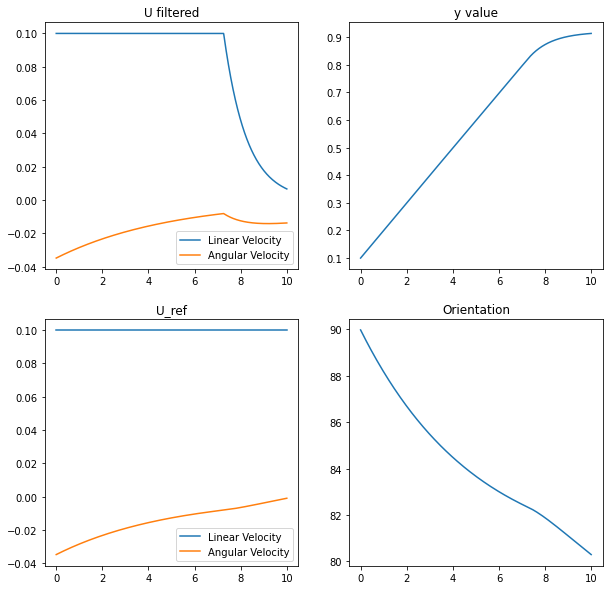

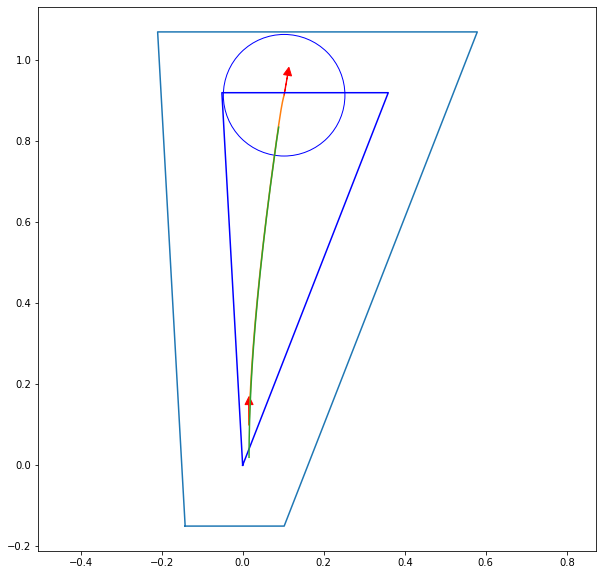

In [133]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
t_axis = np.linspace(0,n_time_steps*del_t,n_time_steps)
axes[0][0].plot(t_axis,U_traj[0,:])
axes[0][0].plot(t_axis,U_traj[1,:])
axes[0][0].legend(['Linear Velocity','Angular Velocity'])
axes[0][0].set_title("U filtered")

axes[1,0].plot(t_axis,U_ref_traj[0,:])
axes[1,0].plot(t_axis,U_ref_traj[1,:])
axes[1,0].legend(['Linear Velocity','Angular Velocity'])
axes[1,0].set_title("U_ref")

axes[1,1].plot(t_axis,Xc_traj[2,:]*180/np.pi)
axes[1,1].set_title("Orientation")

axes[0,1].plot(t_axis,Xc_traj[1,:])
axes[0,1].set_title("y value")
plt.show()


# Plotting Trajectory
fig, ax = plt.subplots(figsize = (10,10))

# Computation of the points for the safeset
xl,yl = safeset.get_cartesian(safeset.best_safe_set_config['left_robot_point'])
xr,yr = safeset.get_cartesian(safeset.best_safe_set_config['right_robot_point'])
r_min = safeset.best_safe_set_config['r_min']
r0 = robot_config['r0']
cl = yl-np.tan(t2)*xl
cr = yr-np.tan(t1)*xr
y_points = [-r0,r_min,r_min,-r0,-r0]
x_points = [(-r0-cl)/np.tan(t2),(r_min-cl)/np.tan(t2),(r_min-cr)/np.tan(t1),(-r0-cr)/np.tan(t1),(-r0-cl)/np.tan(t2)]

ax.plot(x_points,y_points)
ax.plot([0,depth/np.tan(t1),depth/np.tan(t2),0],[0,depth,depth,0],color='b')
circle = patches.Circle((Xc[0,0], Xc[1,0]), robot_config['r0'], fill=False, color='blue')
ax.add_patch(circle)

ax.axis('equal')

ax.plot(Xc_traj[0,:],Xc_traj[1,:])
ax.plot(Xp_traj[0,:],Xp_traj[1,:])


def draw_arrow(ax,x,arrow_length = 0.1):
    arr_obj = ax.arrow(x[0],x[1],arrow_length*np.cos(x[2]),arrow_length*np.sin(x[2]),head_width=0.02, head_length=0.02,color='r')
    return ax,arr_obj

ax,_ = draw_arrow(ax,Xc_traj[:,0],arrow_length=0.05)
ax,_ = draw_arrow(ax,Xc_traj[:,-1],arrow_length=0.05)


/var/folders/pw/pb93h1ws5dx02zs9x_45hk4w0000gn/T/ipykernel_56660/20239659.py:63: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(x, y)


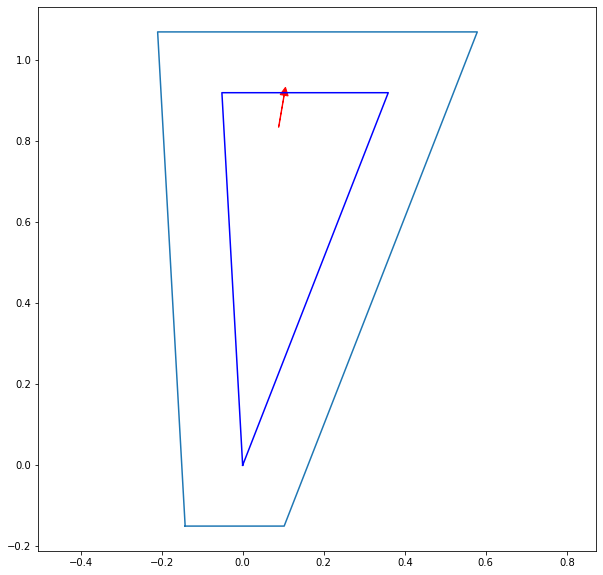

In [134]:
fig, ax = plt.subplots(figsize = (10,10))

ax.set_xlim(-0.4,0.8)
ax.set_ylim(-0.1,2)
ax.plot([0,depth/np.tan(t1),depth/np.tan(t2),0],[0,depth,depth,0],color='b')
ax.axis('equal')

xl,yl = safeset.get_cartesian(safeset.best_safe_set_config['left_robot_point'])
xr,yr = safeset.get_cartesian(safeset.best_safe_set_config['right_robot_point'])
r_min = safeset.best_safe_set_config['r_min']
r0 = robot_config['r0']
cl = yl-np.tan(t2)*xl
cr = yr-np.tan(t1)*xr
y_points = [-r0,r_min,r_min,-r0,-r0]
x_points = [(-r0-cl)/np.tan(t2),(r_min-cl)/np.tan(t2),(r_min-cr)/np.tan(t1),(-r0-cr)/np.tan(t1),(-r0-cl)/np.tan(t2)]

ax.plot(x_points,y_points)


# Initialize an empty point that will represent the moving point
point, = ax.plot([], [], 'ro')
point_c, = ax.plot([],[],'bo')
_,arrow_obj = draw_arrow(ax,Xc_traj[:,0],arrow_length=0.05)
# arrow = patches.Arrow(0.1, 0.1, 0.3, 0.3, width=0.02, edgecolor='black', facecolor='blue')

line, = ax.plot([], [], lw = 3) 
circle, = ax.plot([], [], lw = 3) 

# line, = ax.plot()

# circle = plt.Circle((0, 0), robot_config['r0'], color='orange', fill=False)

# Add the circle to the plot
# ax.add_patch(circle)

# Function to initialize the plot
def init():
    point.set_data([], [])
    point_c.set_data([], [])
    line.set_data([], []) 
    circle.set_data([],[])

    # return (point,point_c),

# Function to update the plot for each frame
def update(frame):
    theta = Xp_traj[2,frame]
    x, y = Xp_traj[0,frame], Xp_traj[1,frame]
    xc,yc = Xc_traj[0,frame], Xc_traj[1,frame]
    line.set_data([x,xc], [y,yc]) 

    theta_range = np.arange(0,2*np.pi,0.02)
    x_circle = xc+r0*np.cos(theta_range)
    y_circle = yc+r0*np.sin(theta_range)
    circle.set_data(x_circle,y_circle)
    # Adds an Arrow
    if l>0:
        arrow_obj.set_data(x=xc,y=yc,dx=l*np.cos(theta),dy=l*np.sin(theta))
        point_c.set_data(xc,yc)

    if l<0:
        arrow_obj.set_data(x=x,y=y,dx=-l*np.cos(theta),dy=-l*np.sin(theta))
        point.set_data(x, y)


    # circle = plt.Circle((xc,yc), robot_config['r0'], color='orange', fill=False)

    # Add the circle to the plot
    # ax.scatter(xc,yc)
    # ax.add_patch(circle)

# Create the animation
ani = FuncAnimation(fig, update, frames=n_time_steps-1, interval = del_t*1000,init_func=init, blit=False)

HTML(ani.to_html5_video())

#### Displaying Safe Set in a Numpy Array

In [ ]:
# Class implementation

def get_points(self,theta,depth):
    other_point = (depth/np.tan(theta),depth)
    return [(0,0),other_point]
def render_safe_set(self):

    img_height = self.img_height
    img_width = self.img_width
    t1 = self.safeset['t1']
    t2 = self.safeset['t2']
    depth = self.safeset['depth']

    canvas = np.ones(shape=(img_height,img_width,3))
    # Define the color (BGR format, (0, 0, 255) is red)
    color = (0, 10, 0)
    thickness = 10

    # Define the radius of the circle (in pixels)
    radius = 2

    right_line = self.get_points(t1,depth)
    left_line = self.get_points(t2,depth)

    cv2.line(canvas, get_X_pixel(*right_line[0]), get_X_pixel(*right_line[1]), color, thickness)
    cv2.line(canvas, get_X_pixel(*left_line[0]), get_X_pixel(*left_line[1]), color, thickness)
    cv2.line(canvas, get_X_pixel(*left_line[1]), get_X_pixel(*right_line[1]), color, thickness)

    cv2.circle(canvas, get_X_pixel(x_local,y_local),radius, color=(0,0,255), thickness=2)

    self.rendered_safe_set = canvas
plt.imshow(canvas)

In [171]:
img_width = 1920
img_height = 1080
y_limit = 3

scale = img_height/y_limit
x_limit = (img_width/img_height)*y_limit

def get_points(theta,depth):
    other_point = (depth/np.tan(theta),depth)
    return [(0,0),other_point]

def get_X_pixel(x_local,y_local):
    # Converts from continuous coordinate system to pixel indices in the np image

    # Equate them to self. ...
    # img_width = 320
    # img_height = 240
    # y_limit = 3

    # scale = img_height/y_limit
    # x_limit = (img_width/img_height)*y_limit

    y_shift = y_limit
    x_shift = -x_limit/2
    X_pixel = np.array([[0,-1],[1,0]])@np.array([[x_local-x_shift],[y_local-y_shift]])*scale
    x_pixel,y_pixel = int(X_pixel[0,0]),int(X_pixel[1,0])
    return y_pixel,x_pixel


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


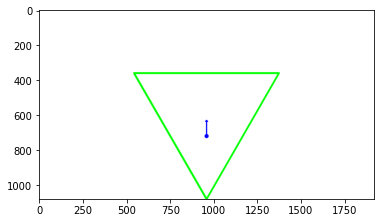

In [187]:
t1 = 60*np.pi/180
t2 = 120*np.pi/180
depth = 2

x_local = 0
y_local = 1
yaw_local = np.pi/2

def render_safe_set():

    # img_height = img_height
    # img_width = img_width
    # t1 = safeset['t1']
    # t2 = safeset['t2']
    # depth = safeset['depth']

    canvas = np.ones(shape=(img_height,img_width,3))
    # Define the color (BGR format, (0, 0, 255) is red)
    arrow_len = 0.25
    color = (0, 10, 0)
    thickness = int(img_height/100)

    # Define the radius of the circle (in pixels)
    radius = 2

    right_line = get_points(t1,depth)
    left_line = get_points(t2,depth)

    cv2.line(canvas, get_X_pixel(*right_line[0]), get_X_pixel(*right_line[1]), color, thickness)
    cv2.line(canvas, get_X_pixel(*left_line[0]), get_X_pixel(*left_line[1]), color, thickness)
    cv2.line(canvas, get_X_pixel(*left_line[1]), get_X_pixel(*right_line[1]), color, thickness)

    cv2.circle(canvas, get_X_pixel(x_local,y_local),radius, color=(0,0,255), thickness=2*thickness)


    x2 = x_local+arrow_len*np.cos(yaw_local)
    y2 = y_local+arrow_len*np.sin(yaw_local)

    cv2.arrowedLine(canvas,get_X_pixel(x_local,y_local),get_X_pixel(x2,y2),color = (0,0,255),thickness=int(thickness/2))

    return canvas

plt.imshow(render_safe_set())


### Control Synthesis (Old Code - Only Linear Velocity Control Optimisation)

In [8]:
def get_G_h_opt_old(t1,t2,d_set,X,gamma,U_ref):
    '''
    h_list: List of Control Barrier Functions coefficients a,b
    X: The state (x,y,theta)

    Returns the matrices used in the inequality constraint of the optimisation problem
    G_opt x U <= h_opt
    '''
    # Used to define the CBFs
    if 0<=t1<np.pi/2:
        a1 = np.array([[-np.tan(t1),1,0]])
    elif np.pi/2<t1<np.pi:
        a1 = np.array([[np.tan(t1),-1,0]])
    b1 = np.array([[0]])

    if 0<=t2<np.pi/2:
        a2 = np.array([[np.tan(t2),-1,0]])
    elif np.pi/2<t2<np.pi:
        a2 = np.array([[-np.tan(t2),1,0]])

    b2 = np.array([[0]])

    a3 = np.array([[0,-1,0]])
    b3 = np.array([[d_set]])

    h_list = [[a1,b1],[a2,b2],[a3,b3]]
    
    G_model = np.array([[np.cos(X[2]),0],[np.sin(X[2]),0],[0,1]])
    # G_model: The Matrix G in the control affine model x_dot = f(x) + g(x)u

    G_opt_list = []
    h_opt_list = []
    for i in range(len(h_list)):
        h_i = h_list[i]
        a_i = h_i[0]
        b_i = h_i[1]
        h_i_val = a_i@X + b_i
        
        assert h_i_val>=0, "CBF Coeffs: {}, X: {}, CBF Value: {}".format(h_i,X,h_i_val) #For safe Set, if this fails, the algo collapses

        G_opt_i = -a_i@G_model
        h_opt_i = gamma*h_i_val + a_i@G_model@U_ref

        G_opt_list.append(G_opt_i)
        h_opt_list.append(h_opt_i)

    G_opt = np.vstack(G_opt_list)
    h_opt = np.vstack(h_opt_list)

    info = {'h_list':h_list,'G_opt':G_opt,'h_opt':h_opt,'G_model':G_model}
    return G_opt,h_opt,info

def get_U_old(t1,t2,d_set,X,gamma,U_ref):
    G_opt, h_opt,info = get_G_h_opt_old(t1,t2,d_set,X,gamma,U_ref)

    Q = matrix(np.eye(2))
    p = matrix(np.zeros(shape=(2,1)))
    G = matrix(G_opt)
    h = matrix(h_opt)

    solvers.options['show_progress'] = False
    sol = solvers.qp(Q, p, G, h)

    U_dash = np.array(sol['x']).reshape(2,1)
    U = U_dash+U_ref


    return U,info

Reference Control v: 1.00,w: 0.00
Optimal Control v: 0.05,w: 0.00


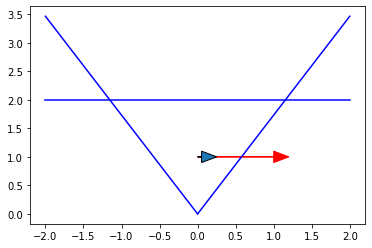

In [9]:
# Used to define the Safe Set
# t1 = safeset.best_safe_set_config['Shrunk_theta1']
# t2 = safeset.best_safe_set_config['Shrunk_theta2']
# d_set = safeset.best_safe_set_config['Shrunk_depth']

t1 = np.pi/3
t2 = 2*np.pi/3
d_set = depth



X0 = np.array([0,1,0])
X = X0

U_ref = np.array([[1],[0]])
gamma = 0.09

U,info_old = get_U_old(t1,t2,d_set,X,gamma,U_ref)

print("Reference Control v: {:.2f},w: {:.2f}".format(U_ref[0,0],U_ref[1,0]))
print("Optimal Control v: {:.2f},w: {:.2f}".format(U[0,0],U[1,0]))

xlim=2
plt.plot([0,xlim],[0,np.tan(t1)*xlim],color='b')
plt.plot([0,-xlim],[0,np.tan(t2)*-xlim],color='b')
plt.plot([-xlim,xlim],[depth,depth],color='b')
arrow_length = U_ref[0,0]
plt.arrow(X0[0],X0[1],arrow_length*np.cos(X0[2]),arrow_length*np.sin(X0[2]),head_width=0.2, head_length=0.2,color='r')
arrow_length = U[0,0]
plt.arrow(X0[0],X0[1],arrow_length*np.cos(X0[2]),arrow_length*np.sin(X0[2]),head_width=0.2, head_length=0.2)

plt.show()

In [40]:
t1 = np.pi/3
t2 = 2*np.pi/3
d_set = depth



X0 = np.array([0,1,0])
X = X0

U_ref = np.array([[0.1],[0]])
gamma = 1

In [41]:
U,info_old = get_U_old(t1,t2,depth,X,gamma,U_ref)

info_old


{'h_list': [[array([[-1.73205081,  1.        ,  0.        ]]), array([[0]])],
  [array([[1.73205081, 1.        , 0.        ]]), array([[0]])],
  [array([[ 0, -1,  0]]), array([[2]])]],
 'G_opt': array([[ 1.73205081,  0.        ],
        [-1.73205081,  0.        ],
        [ 0.        ,  0.        ]]),
 'h_opt': array([[0.82679492],
        [1.17320508],
        [1.        ]]),
 'G_model': array([[1., 0.],
        [0., 0.],
        [0., 1.]])}

In [42]:
X_column = X.reshape(-1,1)
U,info = get_U(t1,t2,depth,X_column,gamma,U_ref,0.08)
info

{'a1': array([-1.73205081,  1.        , -0.08      ]),
 'a2': array([ 1.73205081,  1.        , -0.08      ]),
 'a3': array([ 0.  , -1.  ,  0.08]),
 'G_opt': array([[ 1.73205081,  0.08      ],
        [-1.73205081,  0.08      ],
        [-0.        , -0.08      ]]),
 'h_opt': array([[0.96535898],
        [1.03464102],
        [1.        ]]),
 'B_model': array([[1., 0.],
        [0., 0.],
        [0., 1.]])}

In [43]:
1.1386-0.1732

0.9654

#### Test Value 1

In [207]:
t1 = np.pi/3
t2 = 2*np.pi/3
d_set = 2
X0 = np.array([0,0,np.pi/2])
X = X0

U_ref = np.array([[1],[0]])
gamma = 10


G_opt1,h_opt1 = get_G_h_opt(t1,t2,d_set,X,gamma,U_ref)

G_test1 = np.array([[-1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]])

h_test1 = np.array([[1],[-1],[19]])

print(G_opt1)
print(G_test1)

print(h_test1)
print(h_opt1)

[[-1.73205081  1.          0.        ]]
[[6.123234e-17 0.000000e+00]
 [1.000000e+00 0.000000e+00]
 [0.000000e+00 1.000000e+00]]
[[-1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
[[-1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
[[ 1]
 [-1]
 [19]]
[[ 1.]
 [-1.]
 [19.]]


#### Test Value 2

In [209]:
a1 = np.array([-1.732,1,0])
a2 = np.array([-1.732,-1,0])
a3 = np.array([0,-1,0])
g_model = np.array([[0.5,0],[0.866,0],[0,1]])
U_ref = np.array([[1],[0]])
gamma = 10


t1 = np.pi/3
t2 = 2*np.pi/3
d_set = 2
X0 = np.array([0,0,np.pi/3])

X = X0

U_ref = np.array([[1],[0]])
gamma = 10
get_G_h_opt(t1,t2,d_set,X,gamma,U_ref)


[[-1.73205081  1.          0.        ]]
[[0.5       0.       ]
 [0.8660254 0.       ]
 [0.        1.       ]]


(array([[0.        , 0.        ],
        [1.73205081, 0.        ],
        [0.8660254 , 0.        ]]),
 array([[ 0.        ],
        [-1.73205081],
        [19.1339746 ]]))

In [202]:
gamma*2+a3@g_model@U_ref

array([19.134])

### Older Algos

In [2]:
def get_sliced_img(img,row_frac):
    '''Returns an RGB image with a red line indicating the where the depth slice is taken from'''
    slice_thickness = 0.01

    h,_,_ = img.shape
    row = int(row_frac*h)

    img_sliced = img.copy()
    img_sliced[row-int(slice_thickness*h):row+int(slice_thickness*h),:] = [255,0,0]
    return img_sliced

def get_slice(depth_img,row_frac):
    '''Returns the list of depths taken at the slice of the depth image'''
    h,w = depth_img.shape
    slice = depth_img[int(h*row_frac),:]

    return slice

def get_points(depth_1d,x_range):
    '''Returns the Points as (N,2) array from the sliced array of depths'''
    w = len(depth_1d)
    x_axis = np.linspace(x_range[0],x_range[1],w)

    y_axis_points = depth_1d.copy()
    y_axis_points[0] = 0
    y_axis_points[-1] = 0
    return np.hstack([x_axis.reshape(-1,1),y_axis_points.reshape(-1,1)])

def get_p2(angle,x_max,y_max):
    '''
    x_max: Upper limit for the x_axis
    y_max: Upper limit for the y_axis
    Returns the second point to find the line of slope=tan(angle), The first point is the origin
    '''
    theta1 = np.arctan2(y_max,x_max)*180/np.pi #in degrees
    theta2 = (180-theta1) #in degrees

    if angle>=0 and angle<=theta1:
        m = np.tan(angle*np.pi/180)
        p2 = (x_max,m*x_max)
    elif angle>theta1 and angle<=theta2:
        if angle==90:
            p2 = (0,y_max)
        else:
            m = np.tan(angle*np.pi/180)
            p2 = (y_max/m,y_max)


    elif angle>=theta2 and angle<180:
        m = np.tan(angle*np.pi/180)
        p2 = (-x_max,-m*x_max)
    else:
        print('angle (={})is not within 0 to 180'.format(angle))
    
    return p2


def get_intersection_points(depth_line,angle_range,x_max,y_max,shrinking_factor):
    '''
    angle_range: Search space for the angles to find the intersection points
    shrinking_factor: The point of intersection is brought slightly closer to the origin by point*shrinking_factor
    Returns the intersection points between the lines and the depth line
    '''

    intersection_points = {}
    for angle in angle_range:
        p1 = (0,0)
        p2 = get_p2(angle,x_max=x_max,y_max=y_max)
        line = LineString([p1,p2])

        intersection_result = depth_line.intersection(line)
        if intersection_result.is_empty:
            print("No Intersection Point Found")
            raise

        elif intersection_result.geom_type == 'Point':
            intersection_point = intersection_result
            intersection_point_shrunk = Point(shrinking_factor*intersection_point.x,shrinking_factor*intersection_point.y)
            intersection_points[angle] = intersection_point_shrunk
            # intersection_points[angle] = ((intersection_point.x,intersection_point.y))
            # print(intersection_point.x,intersection_point.y)

        elif intersection_result.geom_type == 'MultiPoint':
            points = list(intersection_result.geoms)
            intersection_point = min(points,key=lambda p:abs(p.x))
            intersection_point_shrunk = Point(shrinking_factor*intersection_point.x,shrinking_factor*intersection_point.y)
            intersection_points[angle] = intersection_point_shrunk


            # intersection_points.append((intersection_point.x,intersection_point.y))
            # print(intersection_point.x,intersection_point.y)
        
    return intersection_points

def get_best_safe_set(intersection_points,depth_line,angle_range,num_angle_steps,angle_resolution,p2_dict,reference_angle,include_deviation_cost = True):
    '''
    intersection_points : Dictionary Object where key is angle and value is Coordinates
    depth_line          : LineString Object from shapely library
    num_angle_steps     : A given safe set has an angle range of (-num_angle_steps*angle_resolution,+num_angle_steps*angle_resolution)
    p2_dict             : Precomputed list of p2 points used to find lines originating from the origin
    reference_angle     : Reference angle for the robot to follow (given by the higher level controller)
    include_deviation_cost: Used to indicate if Deviation from Reference Angle needs to be incorporated
    '''
    
    min_cost = np.inf
    best_p_mid = None
    best_safe_set = None
    for angle in angle_range:
        angle_lower_bound = max(angle_range[0],angle-num_angle_steps*angle_resolution)
        angle_upper_bound = min(angle_range[-1],angle+num_angle_steps*angle_resolution)

        p1 = (0,0)
        p2 = intersection_points[angle_lower_bound]
        p3 = intersection_points[angle_upper_bound]

        linear_ring = LinearRing([p1,p2,p3])
        intersection_obj = depth_line.intersection(linear_ring)
        p_mid = Point((0,2))

        if intersection_obj.is_empty:
            
            p_angle = p2_dict[angle]
            p_angle_line = LineString([(0,0),p_angle])
            p2_p3 = LineString([p2,p3])

            p_mid = p2_p3.intersection(p_angle_line)

            depth_of_safe_set = p_mid.y
            if depth_of_safe_set==0:
                continue
            deviation_from_reference = abs(angle-reference_angle)/180


        
            if include_deviation_cost:
                cost = deviation_from_reference/depth_of_safe_set
            else:
                cost = 1/depth_of_safe_set
            if cost<min_cost:
                min_cost = cost
                best_angle = angle
                best_p_mid = p_mid
                best_safe_set = linear_ring
                optimal_deviation_value = deviation_from_reference
                best_depth = depth_of_safe_set


            print("Angle: {:3.0f},Depth:{:2.2f},Deviation:{:2.2f},cost:{:2.2f}".format(angle,depth_of_safe_set,deviation_from_reference,cost))
            # print((angle_lower_bound,angle_upper_bound),"No Intersection")

    return best_angle,min_cost,best_p_mid,best_safe_set,optimal_deviation_value,best_depth

def get_ax(depth_line,best_safe_set,best_p_mid,x_axis_range,y_max,scatter=True):
    
    x_coords,y_coords = depth_line.xy

    polygon_edge_color = 'g'
    polygon_face_color = 'lightgreen'
    safe_set_polygon = Polygon(list(zip(*best_safe_set.xy)),closed=True, edgecolor=polygon_edge_color, facecolor=polygon_face_color)

    fig, ax = plt.subplots(figsize=(10,10))
    if scatter:
        ax.scatter(x_coords,y_coords)
    else:
        ax.plot(x_coords,y_coords)
    ax.add_patch(safe_set_polygon)
    ax.scatter(best_p_mid.x,best_p_mid.y)

    ax.set_xlim(*x_axis_range)
    ax.set_ylim(0,y_max)
    ax.set_aspect('equal')


    return ax,fig


In [22]:
depth_img = np.load('Data_Files/FirstFrame_Depth.npy')
slice_height = 0.6

depth_1d = (get_slice(depth_img,slice_height))

(1920,)

In [3]:
depth_img = np.load('Data_Files/FirstFrame_Depth.npy')
rgb_img = np.load('Data_Files/FirstFrame_RGB.npy')

depth_max = 3
depth_min = 0
x_axis_range = (-1,1)

slice_height = 0.6

y_max = depth_max
x_max = x_axis_range[1]

depth_1d = (get_slice(depth_img,slice_height))
w = len(depth_1d)

depth_points = get_points(depth_1d,x_axis_range)
depth_line = LineString(depth_points)

y_max = depth_max
x_max = x_axis_range[1]
angle_resolution = 5

angle_range = np.arange(0,180,angle_resolution)
shrinking_factor = 0.98




p2_dict = {}
for angle in angle_range:
    p2 = get_p2(angle,x_max,y_max)
    p2_dict[angle] = p2


best_angle = 90
reference_angle = 90
num_angle_steps = 2
include_deviation_cost = False
intersection_points = get_intersection_points(depth_line=depth_line,angle_range=angle_range,x_max=x_max,y_max=y_max,shrinking_factor=shrinking_factor)
best_angle, min_cost, best_p_mid,best_safe_set,optimal_deviation_value,optimal_depth = get_best_safe_set(intersection_points,depth_line,angle_range,num_angle_steps,angle_resolution,p2_dict,reference_angle,include_deviation_cost)
print("Angle for Optimal Safe Set: {:.2f}, Deviation Angle for Optimal Safe Set: {:.2f}, Depth of Optimal Safe Set: {:.2f}, Cost of Optimal Safe Set:{:.2f} ".format(best_angle,optimal_deviation_value,optimal_depth,min_cost))
get_ax(depth_line,best_safe_set,best_p_mid,x_axis_range,y_max,scatter=False)

FileNotFoundError: [Errno 2] No such file or directory: 'Data_Files/FirstFrame_Depth.npy'

In [28]:
def get_sliced_img(img,row_frac):
    slice_thickness = 0.01

    h,_,_ = img.shape
    row = int(row_frac*h)

    img_sliced = img.copy()
    img_sliced[row-int(slice_thickness*h):row+int(slice_thickness*h),:] = [255,0,0]
    return img_sliced

def get_slice(depth_img,row_frac):
    h,w = depth_img.shape
    slice = depth_img[int(h*row_frac),:]

    return slice

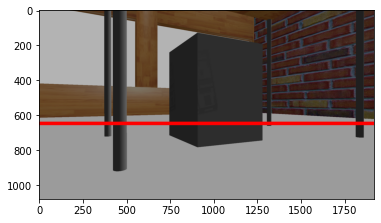

In [29]:
slice_height = 0.6
rgb_img_switched = rgb_img[..., ::-1]
rgb_img_slice = get_sliced_img(rgb_img_switched,slice_height)
plt.imshow(rgb_img_slice)

In [23]:
slice_height = 0.6
rgb_img_switched = rgb_img[..., ::-1]
rgb_img_slice = get_sliced_img(rgb_img_switched,slice_height)
plt.imshow(rgb_img_slice)

plt.imshow(depth_img,cmap='gray')

NameError: name 'rgb_img' is not defined

[0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.19 0.19]


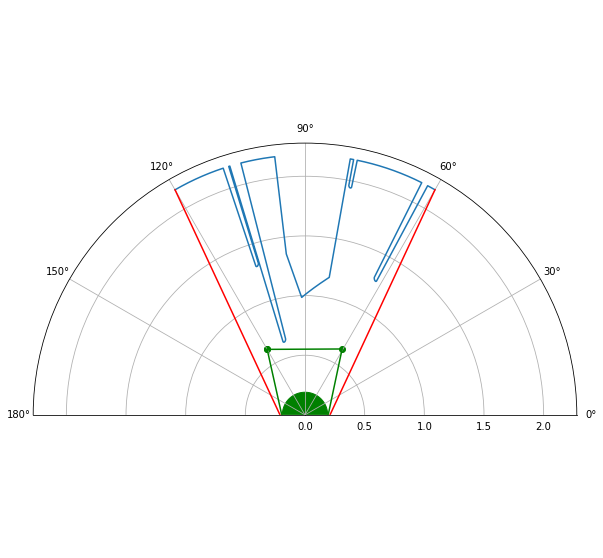

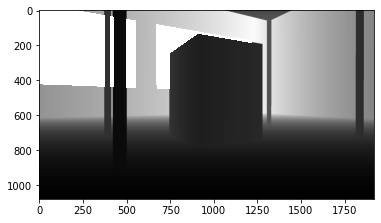

In [16]:
plt.imshow(depth_img,cmap='gray')

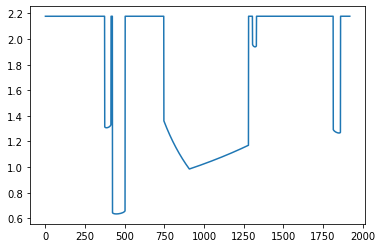

In [20]:
plt.plot(depth_1d)

In [12]:
polar_img = np.load('Some NPY Files/PolarPlot.npy')

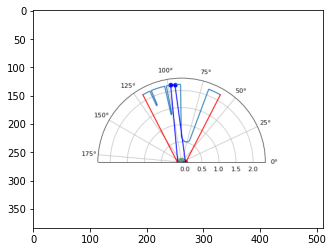

In [13]:
plt.imshow(polar_img)

In [2]:
def get_tangent_coordinates(theta,d,r0):
    '''
    d,theta: Polar Coordinates of the point
    r0: Radius of the Robot

    Returns the 2 Points of Intersections of the tangents from a point to a circle
    '''
    if d<=r0:
        print(d)
        raise
    phi = np.arccos(r0/d)
    

    assert 0<phi<np.pi/2,"Phi: ,r0: ,d: ".format(phi,r0,d)

    left_point = (theta+phi,r0)
    right_point = (theta-phi,r0)
    points = [left_point,right_point]
    return points

In [32]:
def get_left_right_extremes(theta_min,theta_max,radial_distances):
    '''
    Returns the left and right tangent points on the robot for theta_min and theta_max
    '''

    right_extreme_depth = (theta_min,radial_distances[-1])
    _,right_extreme_robot = get_tangent_coordinates(right_extreme_depth[0],right_extreme_depth[1],r0)

    left_extreme_depth = (theta_max,radial_distances[0]) #Left Extreme point of the Depth Line (Blue) in Polar Coordinates
    left_extreme_robot,_ = get_tangent_coordinates(left_extreme_depth[0],left_extreme_depth[1],r0)

    return left_extreme_robot,right_extreme_robot

def get_ax_polar(radial_distances,theta_min,theta_max,r0,theta_axis,r_limit):
    '''
    Returns the ax object populated with depth_line and end tangents
    '''
    ax = plt.subplot(polar=True)
    ax.plot(theta_axis,radial_distances)
    # Plot radial lines
    # ax.plot([theta_min, theta_min], [0, 2.5], color='r', linestyle='-', linewidth=2, label='Theta 1')
    # ax.plot([theta_max, theta_max], [0, 2.5], color='r', linestyle='-', linewidth=2, label='Theta 2')



    theta_robot_fill = np.linspace(0, 2 * np.pi, 100)  # Create 100 points around the circumference
    r = np.full_like(theta_robot_fill, r0)  # Set the radius for all points

    # Plot the circle
    ax.fill(theta_robot_fill, r, color='green')

    # Plotting Extreme Left and Right Tangents
    #Left Extreme Tangent
    left_extreme_depth = (theta_max,radial_distances[0]) #Left Extreme point of the Depth Line (Blue) in Polar Coordinates
    left_extreme_robot,_ = get_tangent_coordinates(left_extreme_depth[0],left_extreme_depth[1],r0)
    ax.plot([left_extreme_depth[0],left_extreme_robot[0]],[left_extreme_depth[1],left_extreme_robot[1]],color='r')

    #Right Extreme Tangent
    right_extreme_depth = (theta_min,radial_distances[-1])
    _,right_extreme_robot = get_tangent_coordinates(right_extreme_depth[0],right_extreme_depth[1],r0)
    ax.plot([right_extreme_depth[0],right_extreme_robot[0]],[right_extreme_depth[1],right_extreme_robot[1]],color='r')

    #Setting Limits
    # ax.set_thetamin((theta_min-np.pi/2)*180/np.pi)
    # ax.set_thetamax((theta_max+np.pi/2)*180/np.pi)
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    ax.set_rmax(r_limit)
    

    return ax

In [33]:
def get_robot_points(theta1,theta2,rs,r0):
    '''
    theta1: Angular Distance of Right Point, lower angle wrt x-axis
    theta2: Angular Distance of Left Point, higher angle wrt x-axis
    rs: Min Radial Distance in (theta1,theta2)
    r0: Robot Radius
    Returns the two points on the Robot
    '''
        
    _,right_robot_point = get_tangent_coordinates(theta1,rs,r0)
    left_robot_point,_ = get_tangent_coordinates(theta2,rs,r0)

    return left_robot_point,right_robot_point
    left_robot_point,_ = get_tangent_coordinates(left_extreme_depth[0],left_extreme_depth[1],r0)

def get_cartesian(polar_coords):
    '''
    polar_coords: A tuple
    '''
    theta,r = polar_coords
    return r*np.cos(theta),r*np.sin(theta)


def get_depth_points_cartesian(theta_axis,radial_distances,left_extreme_robot,right_extreme_robot):
    '''
    Used to build the depth_line
    '''
    x_axis_points = (radial_distances*np.cos(theta_axis)).reshape(-1,1)
    y_axis_points = (radial_distances*np.sin(theta_axis)).reshape(-1,1)

    left_extreme_robot_cartesian = get_cartesian(left_extreme_robot)
    right_extreme_robot_cartesian = get_cartesian(right_extreme_robot)

    x_axis_points[0,0] = left_extreme_robot_cartesian[0]
    y_axis_points[0,0] = left_extreme_robot_cartesian[1]

    x_axis_points[-1,0] = right_extreme_robot_cartesian[0]
    y_axis_points[-1,0] = right_extreme_robot_cartesian[1]

    return np.hstack([x_axis_points,y_axis_points])
    

def get_safe_set_points_cartesian(safe_set_points,shrinking_factor=0.99):
    '''
    Used to form the linear ring to check intersection with depth line
    '''
    safe_set_points_cartesian = np.hstack([shrinking_factor*safe_set_points[:,1:2]*np.cos(safe_set_points[:,0:1]),shrinking_factor*safe_set_points[:,1:2]*np.sin(safe_set_points[:,0:1])])
    return safe_set_points_cartesian

def plot_best_safe_set(best_safe_set_config):
    '''
    Plots the Depth Data with the best safe set in polar coordinates
    '''
    theta1 = best_safe_set_config['theta1']
    theta2 = best_safe_set_config['theta2']
    left_robot_point = best_safe_set_config['left_robot_point']
    right_robot_point = best_safe_set_config['right_robot_point']
    left_depth_point = best_safe_set_config['left_depth_point']
    right_depth_point = best_safe_set_config['right_depth_point']
    r_min = best_safe_set_config['r_min']


    fig = plt.figure(figsize=(10, 10))
    ax = get_ax_polar(radial_distances,theta_min,theta_max,r0,theta_axis,r_limit)
    safe_set_points = np.array([left_depth_point,left_robot_point,right_robot_point,right_depth_point,left_depth_point])
    ax.scatter(safe_set_points[:,0],safe_set_points[:,1],c='b',linewidths=1)
    ax.plot(safe_set_points[:,0],safe_set_points[:,1],c='b')
    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data

def plot_safe_set(i,j,radial_distances,theta_min,theta_max,r0,theta_axis,r_limit,k_depth,k_angular,k_deviation):
    '''
    Plots the Safe Set corresponding to theta_i and theta_j (Used for Testing)
    '''
    r_min = depth_points[i:j,1].min()  # 1 represents index for radial distance!
    theta1 = depth_points[j,0]
    theta2 = depth_points[i,0]

    left_robot_point, right_robot_point = get_robot_points(theta1=theta1,theta2=theta2,rs=r_min,r0=r0)
    if left_robot_point[0]-right_robot_point[0]<np.pi:
        print("Safe Set Unfeasible")

    deviation_component = abs(np.pi/2+ref_direction-(theta1+theta2)/2)/fov
    angular_component = (theta2-theta1)/fov

    safe_set_metric = k_depth*r_min/max_depth + k_angular*angular_component + k_deviation*deviation_component

    print("Safe Set Metric: {:.4f}, Depth Component: {:.2f}, Angular Component: {:.2f}, Deviation Component: {:.2f}".format(safe_set_metric,
                                                                                                                            k_depth*r_min,
                                                                                                                            k_angular*angular_component,
                                                                                                                            k_deviation*deviation_component
                                                                                                                            ))
    fig=plt.figure(figsize=(10, 10))
    ax = get_ax_polar(radial_distances,theta_min,theta_max,r0,theta_axis,r_limit)


    left_depth_point = (theta2,r_min)
    right_depth_point = (theta1,r_min)
    safe_set_points = np.array([left_depth_point,left_robot_point,right_robot_point,right_depth_point,left_depth_point])
    ax.scatter(safe_set_points[:,0],safe_set_points[:,1],c='b',linewidths=1)
    ax.plot(safe_set_points[:,0],safe_set_points[:,1],c='b')
    


UsageError: Cell magic `%%` not found.


In [107]:
print(safeset.best_safe_set_config['theta1']*180/np.pi)

print(safeset.best_safe_set_config['theta2']*180/np.pi)

66.84374999999999
76.24999999999999


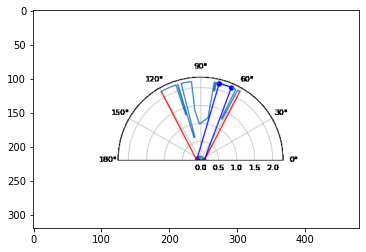

In [38]:
plt.imshow(data)

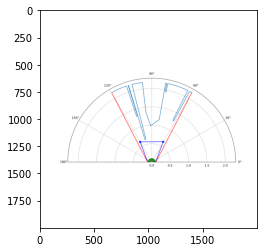

In [31]:
data_py = np.load('data.npy')
plt.imshow(data_py)

In [62]:
depth_1d[100:120] = np.nan

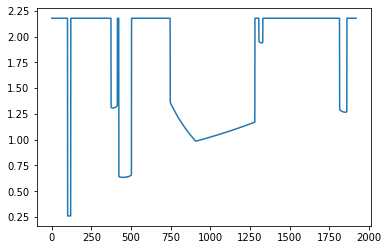

In [74]:
depth_1d_new = np.nan_to_num(depth_1d,nan=0.26)
plt.plot(depth_1d_new)

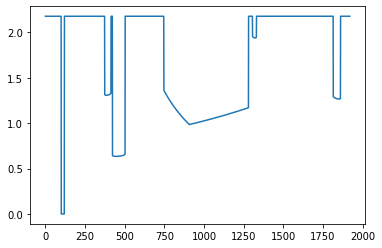

In [36]:
radial_distances = depth_1d
# Specify Values here
theta_min = 2*np.pi/6
theta_max = 4*np.pi/6 #fov of the camera
r_limit = 2.5
max_depth = r_limit

fov = theta_max-theta_min
r0 = 0.1 #radius of robot in metres (obtained from the urdf file)
theta_axis = np.linspace(theta_max, theta_min, len(radial_distances), endpoint=False)

c = 0
t = 0

In [10]:
def main(k_depth,k_angular,k_deviation):

    # depth_points = np.hstack([theta_axis.reshape(-1,1),radial_distances.reshape(-1,1)])
    radial_distances = depth_1d
    # Specify Values here
    theta_min = 2*np.pi/6
    theta_max = 4*np.pi/6 #fov of the camera
    r_limit = 2.5
    max_depth = r_limit

    fov = theta_max-theta_min
    r0 = 0.1 #radius of robot in metres (obtained from the urdf file)
    theta_axis = np.linspace(theta_max, theta_min, len(radial_distances), endpoint=False)

    c = 0
    t = 0

    best_safe_set_metric = 0 #Higher the better
    best_safe_set_config = {}
    # include_deviation_component = False
    # include_angular_component = True
    ref_direction = np.pi/100 #in radians

    
    depth_points = np.hstack([theta_axis.reshape(-1,1),radial_distances.reshape(-1,1)])
    left_extreme_robot,right_extreme_robot = get_left_right_extremes(theta_min,theta_max,radial_distances)
    depth_points_cartesian = (get_depth_points_cartesian(theta_axis,radial_distances,left_extreme_robot,right_extreme_robot))

    print(depth_points_cartesian[100])
    depth_line_s = LineString(depth_points_cartesian)

    for i in range(0,1920,100):
        for j in range(i+1,1920,100):
            
            t+=1
            r_min = depth_points[i:j,1].min()  # 1 represents index for radial distance!
            theta1 = depth_points[j,0]
            theta2 = depth_points[i,0]

            left_robot_point, right_robot_point = get_robot_points(theta1=theta1,theta2=theta2,rs=r_min,r0=r0)
            if left_robot_point[0]-right_robot_point[0]<np.pi: #Checking if the safe set is too narrow
                continue

            left_depth_point = (theta2,r_min)
            right_depth_point = (theta1,r_min)
            safe_set_points = np.array([left_depth_point,left_robot_point,right_robot_point,right_depth_point,left_depth_point])

            safe_set_points_cartesian = get_safe_set_points_cartesian(safe_set_points)
            
            # Checking if the safe set intersects with the depth line
            safe_set_points_s = LinearRing(safe_set_points_cartesian)
            intersection_obj = depth_line_s.intersection(safe_set_points_s)

            if intersection_obj.is_empty:
                c+=1
                deviation_component = abs(np.pi/2+ref_direction-(theta1+theta2)/2)/fov
                angular_component = (theta2-theta1)/fov

                safe_set_metric = k_depth*r_min/max_depth + k_angular*angular_component + k_deviation*deviation_component

                if safe_set_metric>best_safe_set_metric:
                    best_safe_set_metric=safe_set_metric
                    best_safe_set_config['i']=i
                    best_safe_set_config['j']=j
                    best_safe_set_config['theta1'] = theta1
                    best_safe_set_config['theta2'] = theta2
                    best_safe_set_config['r_min'] = r_min
                    best_safe_set_config['Metric'] = safe_set_metric
                    best_safe_set_config['left_robot_point'] = left_robot_point
                    best_safe_set_config['right_robot_point'] = right_robot_point
                    best_safe_set_config['left_depth_point'] = left_depth_point
                    best_safe_set_config['right_depth_point'] = right_depth_point

    feasible_safe_sets_percent = (c/t)*100
    print("Percentage of the Feasible Safe Sets in the searched space: {:.2f}".format(feasible_safe_sets_percent))
    print(best_safe_set_config)
    data = plot_best_safe_set(best_safe_set_config)
    return data
    

In [11]:
slice_height = 0.6

depth_img = np.load('Data_Files/FirstFrame_Depth.npy')
depth_1d = (get_slice(depth_img,slice_height))

k_depth = 1.4
k_angular = 1
k_deviation = 0
data = main(k_depth,k_angular,k_deviation)

NameError: name 'get_left_right_extremes' is not defined

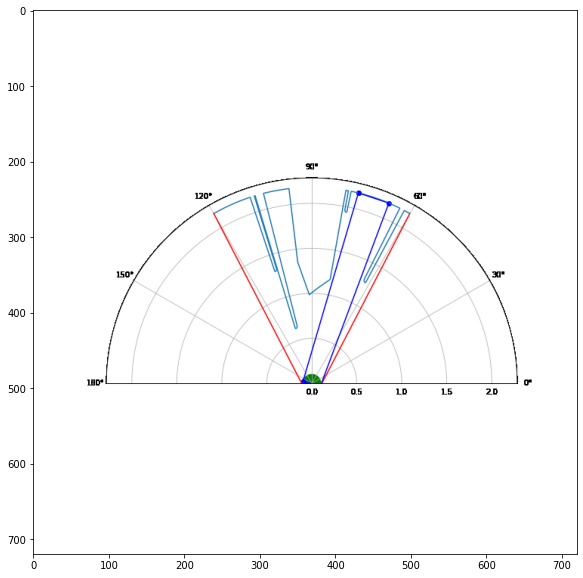

In [630]:
plt.figure(figsize=(10,10))
plt.imshow(data)

### Rough Polar

In [ ]:
t1 = np.pi/3
t2 = 2*np.pi/3
depth = 2

safe_set_config = [t1,t2,depth]
l = 0.08
gamma = 1



Xc = np.array([[-l],[1],[0]])
X = get_Xp(Xc,l)
U_ref = np.array([[0.1],[0]])


t1 = safe_set_config[0]
t2 = safe_set_config[1]
depth = safe_set_config[2]



theta = X[2][0] #extracting theta for easier usage in later formulae

#if either t1 or t2 is a 90 degree angle
if t1==np.pi/2:
    t1 = t1 - 0.1*np.pi/180 #Nudging t1 by 0.1 degree if it is 90 degrees
if t2==np.pi/2:
    t2 = t2 + 0.1*np.pi/180

# Finding a1,a2,a3 depending on theta and safe set config (NOTE: these a_i's are different from that implemented below, look at written notes)
if 0<=t1<np.pi/2:
    a1 = np.array([-np.tan(t1),1,-(l*np.cos(theta)+l*np.sin(theta)*np.tan(t1))])
    h1 = h_val(t1,X,l)

elif np.pi/2<t1<=np.pi:
    a1 = -np.array([-np.tan(t1),1,-(l*np.cos(theta)+l*np.sin(theta)*np.tan(t1))])
    h1 = -h_val(t1,X,l)

if 0<=t2<np.pi/2:
    a2 = np.array([np.tan(t2),-1,l*np.cos(theta)+l*np.sin(theta)*np.tan(t2)])
    h2 = -h_val(t2,X,l)

elif np.pi/2<t2<=np.pi:
    a2 = -np.array([np.tan(t2),-1,l*np.cos(theta)+l*np.sin(theta)*np.tan(t2)])
    h2 = h_val(t2,X,l)

a3 = np.array([0,-1,l*np.cos(theta)])
h3 = -X[1][0]+l*np.sin(theta)+depth

B = np.array([[np.cos(theta),0],[np.sin(theta),0],[0,1]])

# print(h1,h2,h3)
# print(a1,a2,a3)
print(B)

G_opt = -np.vstack([a1@B,a2@B,a3@B])
h_opt = np.vstack([-gamma*h1+a1@B@U_ref,-gamma*h2+a2@B@U_ref,-gamma*h3+a3@B@U_ref])
G_opt

In [ ]:
def plot_safe_set(i,j):
    r_min = depth_points[i:j,1].min()  # 1 represents index for radial distance!
    theta1 = depth_points[j,0]
    theta2 = depth_points[i,0]

    left_robot_point, right_robot_point = get_robot_points(theta1=theta1,theta2=theta2,rs=r_min,r0=r0)
    if left_robot_point[0]-right_robot_point[0]<np.pi:
        print("Safe Set Unfeasible")

    plt.figure(figsize=(10, 10))
    ax = get_ax_polar(radial_distances,theta_min,theta_max,r0,theta_axis,r_limit)

    left_depth_point = (theta2,r_min)
    right_depth_point = (theta1,r_min)
    safe_set_points = np.array([left_depth_point,left_robot_point,right_robot_point,right_depth_point,left_depth_point])
    ax.scatter(safe_set_points[:,0],safe_set_points[:,1],c='b',linewidths=1)
    ax.plot(safe_set_points[:,0],safe_set_points[:,1],c='b')

In [ ]:
i=best_safe_set_config['i']
j=best_safe_set_config['j']
r_min = depth_points[i:j,1].min()  # 1 represents index for radial distance!
theta1 = depth_points[j,0]
theta2 = depth_points[i,0]

left_robot_point, right_robot_point = get_robot_points(theta1=theta1,theta2=theta2,rs=r_min,r0=r0)
if left_robot_point[0]-right_robot_point[0]<np.pi:
    print("Safe Set Unfeasible")





plt.figure(figsize=(10, 10))
ax = get_ax_polar(radial_distances,theta_min,theta_max,r0,theta_axis,r_limit)

left_depth_point = (theta2,r_min)
right_depth_point = (theta1,r_min)
safe_set_points = np.array([left_depth_point,left_robot_point,right_robot_point,right_depth_point,left_depth_point])
ax.scatter(safe_set_points[:,0],safe_set_points[:,1],c='b',linewidths=1)
ax.plot(safe_set_points[:,0],safe_set_points[:,1],c='b')


if left_robot_point[0]-right_robot_point[0]<np.pi:
    print("Safe Set Unfeasible")
ref_direction = np.pi/100 #in radians
deviation_component = abs(np.pi/2+ref_direction-(theta1+theta2)/2)/fov
safe_set_metric = r_min*(theta2-theta1)/deviation_component
safe_set_metric
plt.plot(safe_set_points_cartesian[:,0],safe_set_points_cartesian[:,1])
plt.xlim([-2,2])
plt.ylim([0,2])
safe_set_points_s = LinearRing(safe_set_points_cartesian)
type(safe_set_points_s)
intersection_obj = depth_line_s.intersection(safe_set_points_s)

if intersection_obj.is_empty:
    print("No Intersection")

elif intersection_obj.geom_type == 'Point':
    geoms_list = np.array([[p.x,p.y] for p in [intersection_obj]])
    print(geoms_list)
    plt.plot(safe_set_points_cartesian[:,0],safe_set_points_cartesian[:,1])
    plt.scatter(geoms_list[:,0],geoms_list[:,1])
    plt.xlim([-2,2])
    plt.ylim([0,2])
    print(intersection_obj.x,intersection_obj.y)

elif intersection_obj.geom_type == 'MultiPoint':
    geoms_list = np.array([[p.x,p.y] for p in (list(intersection_obj.geoms))])
    print(geoms_list)
    plt.plot(safe_set_points_cartesian[:,0],safe_set_points_cartesian[:,1])
    plt.scatter(geoms_list[:,0],geoms_list[:,1])
    plt.xlim([-2,2])
    plt.ylim([0,2])

88.75
116.87499999999999
0.6341402530670166


array([[2.03985356, 2.17834759],
       [3.45229507, 0.1       ],
       [0.1365382 , 0.1       ],
       [1.54897971, 1.0253129 ],
       [2.03985356, 2.17834759]])

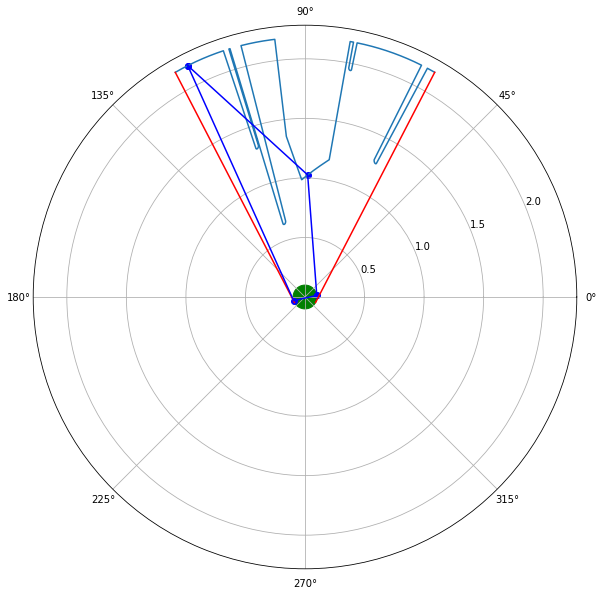

In [58]:
depth_points = np.hstack([theta_axis.reshape(-1,1),radial_distances.reshape(-1,1)])

i = 100
j = 1000
left_depth_point = depth_points[i,:]
right_depth_point = depth_points[j,:]

r_min = depth_points[i:j,1].min()  # 1 represents index for radial distance!
theta1 = right_depth_point[0]
theta2 = left_depth_point[0]
print(theta1*180/np.pi)
print(theta2*180/np.pi)
print(r_min)
left_robot_point, right_robot_point = get_robot_points(theta1=theta1,theta2=theta2,rs=r_min,r0=r0)

plt.figure(figsize=(10, 10))
ax = get_ax_polar(radial_distances,theta_min,theta_max,r0,theta_axis,r_limit)

points = np.array([left_depth_point,left_robot_point,right_robot_point,right_depth_point,left_depth_point])
ax.scatter(points[:,0],points[:,1],c='b',linewidths=1)
ax.plot(points[:,0],points[:,1],c='b')

points

In [ ]:
### Othe

## Other Rough

In [28]:
def scale_angle(angle):
    if -2*np.pi<=angle<-np.pi:
        angle = angle+2*np.pi

    if np.pi<angle<=2*np.pi:
        angle = angle-2*np.pi

    if angle>2*np.pi or angle<-2*np.pi:
        raise 

    return angle

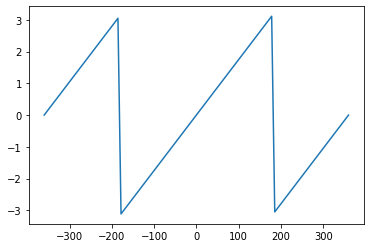

In [31]:
plt.plot(np.linspace(-2*np.pi,2*np.pi,100)*180/np.pi,[scale_angle(theta) for theta in np.linspace(-2*np.pi,2*np.pi,100)])

In [ ]:
depth_1d = (get_slice(depth_img,slice_height))
w = len(depth_1d)

def get_points(depth_1d,x_range):
    w = len(depth_1d)
    x_axis = np.linspace(x_range[0],x_range[1],w)

    y_axis_points = depth_1d.copy()
    y_axis_points[0] = 0
    y_axis_points[-1] = 0
    return np.hstack([x_axis.reshape(-1,1),y_axis_points.reshape(-1,1)])

In [ ]:
depth_points = get_points(depth_1d,x_axis_range)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(depth_points[:,0],depth_points[:,1])

ax.set_ylim(0,3)
ax.set_xlim(-1,1)
ax.set_ylabel('1D Depth')
ax.set_aspect('equal')

In [ ]:
depth_points = get_points(depth_1d,x_axis_range)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(depth_points[:,0],depth_points[:,1])

ax.set_ylim(0,3)
ax.set_xlim(-1,1)
ax.set_ylabel('1D Depth')
ax.set_aspect('equal')

In [ ]:
depth_line = LineString(depth_points)

In [ ]:
y_max = depth_max
x_max = x_axis_range[1]

def get_p2(angle,x_max,y_max):
    theta1 = np.arctan2(y_max,x_max)*180/np.pi #in degrees
    theta2 = (180-theta1) #in degrees

    if angle>=0 and angle<=theta1:
        m = np.tan(angle*np.pi/180)
        p2 = (x_max,m*x_max)
    elif angle>theta1 and angle<=theta2:
        if angle==90:
            p2 = (0,y_max)
        else:
            m = np.tan(angle*np.pi/180)
            p2 = (y_max/m,y_max)


    elif angle>=theta2 and angle<180:
        m = np.tan(angle*np.pi/180)
        p2 = (-x_max,-m*x_max)
    else:
        print('angle (={})is not within 0 to 180'.format(angle))
    
    return p2

In [ ]:
p2_dict = {}
for angle in angle_range:
    p2 = get_p2(angle,x_max,y_max)
    p2_dict[angle] = p2
    

In [ ]:
x_coords,y_coords = zip(*p2_list)
plt.scatter(x_coords,y_coords)

In [ ]:
intersection_points = {}
y_max = depth_max
x_max = x_axis_range[1]
angle_resolution = 5

angle_range = range(0,180,angle_resolution)
shrinking_factor = 0.99


def get_intersection_points(depth_line,angle_range):
    for angle in angle_range:
        p1 = (0,0)
        p2 = get_p2(angle,x_max=x_max,y_max=y_max)
        line = LineString([p1,p2])

        intersection_result = depth_line.intersection(line)
        if intersection_result.is_empty:
            print("No Intersection Point Found")
            raise

        elif intersection_result.geom_type == 'Point':
            intersection_point = intersection_result
            intersection_point_shrunk = Point(shrinking_factor*intersection_point.x,shrinking_factor*intersection_point.y)
            intersection_points[angle] = intersection_point_shrunk
            # intersection_points[angle] = ((intersection_point.x,intersection_point.y))
            # print(intersection_point.x,intersection_point.y)

        elif intersection_result.geom_type == 'MultiPoint':
            points = list(intersection_result.geoms)
            intersection_point = min(points,key=lambda p:abs(p.x))
            intersection_point_shrunk = Point(shrinking_factor*intersection_point.x,shrinking_factor*intersection_point.y)
            intersection_points[angle] = intersection_point_shrunk


            # intersection_points.append((intersection_point.x,intersection_point.y))
            # print(intersection_point.x,intersection_point.y)
        
    return intersection_points
 

In [ ]:
num_angle_steps = 2

intersection_points = get_intersection_points(depth_line=depth_line,angle_range=angle_range)
for angle in angle_range:

    angle_lower_bound = max(angle_range[0],angle-num_angle_steps*angle_resolution)
    angle_upper_bound = min(angle_range[-1],angle+num_angle_steps*angle_resolution)

    p1 = (0,0)
    p2 = intersection_points[angle_lower_bound]
    # p2 = Point(p2_raw.x*shrinking_factor,p2_raw.y*shrinking_factor)
    p3 = intersection_points[angle_upper_bound]
    # p3 = Point(p3_raw.x*shrinking_factor,p3_raw.y*shrinking_factor)


    linear_ring = LinearRing([p1,p2,p3])

    intersection_obj = depth_line.intersection(linear_ring)
    if intersection_obj.is_empty:
        
        print((angle_lower_bound,angle_upper_bound),"No Intersection")


    # elif intersection_obj.geom_type=="Point" or intersection_obj.geom_type=="MultiPoint":
    #     print((angle_lower_bound,angle_upper_bound),"Point Intersections")

    # else:
    #     print((angle_lower_bound,angle_upper_bound),intersection_obj.geom_type)
    


In [ ]:
best_angle = 90
reference_angle = 90
num_angle_steps = 3

def get_best_safe_set(intersection_points,depth_line,angle_range,num_angle_steps,angle_resolution):
    min_cost = np.inf
    best_p_mid = None
    best_safe_set = None
    for angle in angle_range:
        angle_lower_bound = max(angle_range[0],angle-num_angle_steps*angle_resolution)
        angle_upper_bound = min(angle_range[-1],angle+num_angle_steps*angle_resolution)

        p1 = (0,0)
        p2 = intersection_points[angle_lower_bound]
        p3 = intersection_points[angle_upper_bound]

        linear_ring = LinearRing([p1,p2,p3])
        intersection_obj = depth_line.intersection(linear_ring)
        p_mid = Point((0,2))

        if intersection_obj.is_empty:
            
            p_angle = p2_dict[angle]
            p_angle_line = LineString([(0,0),p_angle])
            p2_p3 = LineString([p2,p3])

            p_mid = p2_p3.intersection(p_angle_line)

            depth_of_safe_set = p_mid.y
            deviation_from_reference = abs(angle-reference_angle)/180


            cost = deviation_from_reference/depth_of_safe_set
            if cost<min_cost:
                min_cost = cost
                best_angle = angle
                best_p_mid = p_mid
                best_safe_set = linear_ring


            # print("Angle: {:3.0f},Depth:{:2.2f},Deviation:{:2.2f},cost:{:2.2f}".format(angle,depth_of_safe_set,deviation_from_reference,cost))
            # print((angle_lower_bound,angle_upper_bound),"No Intersection")

    return best_angle,min_cost,best_p_mid,best_safe_set

In [ ]:
best_angle, min_cost, best_p_mid,best_safe_set = get_best_safe_set(intersection_points,depth_line,angle_range,num_angle_steps,angle_resolution)

full_img = unary_union([depth_line,best_p_mid,best_safe_set])

In [ ]:
list(zip(*best_safe_set.xy))




In [ ]:
best_angle, min_cost, best_p_mid,best_safe_set = get_best_safe_set(intersection_points,depth_line,angle_range,num_angle_steps,angle_resolution)


def get_ax(depth_line,best_safe_set):
    x_coords,y_coords = depth_line.xy

    polygon_edge_color = 'g'
    polygon_face_color = 'lightgreen'
    safe_set_polygon = Polygon(list(zip(*best_safe_set.xy)),closed=True, edgecolor=polygon_edge_color, facecolor=polygon_face_color)

    fig, ax = plt.subplots()
    ax.plot(x_coords,y_coords)
    ax.add_patch(safe_set_polygon)

    ax.set_xlim(*x_axis_range)
    ax.set_ylim(0,y_max)

    return ax,fig


In [ ]:
get_ax(depth_line=depth_line,best_safe_set=best_safe_set)

In [ ]:

# Render the Axes content
fig.canvas.draw()

# Convert the rendered content to an RGB image
image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


In [ ]:

plt.imshow(np.array(image))

In [ ]:
# Convert Shapely geometries to matplotlib patches
depth_line_patch = depth_line.buffer(0.05)
best_safe_set_patch = best_safe_set.buffer(0.05)
best_p_mid_patch = best_p_mid.buffer(0.05)

# Create a plot
fig, ax = plt.subplots()

# Add patches to the plot with different colors
ax.add_patch(PolygonPatch(depth_line_patch, fc='blue', ec='black', alpha=0.5))
ax.add_patch(PolygonPatch(best_safe_set_patch, fc='red', ec='black', alpha=0.5))
ax.add_patch(PolygonPatch(best_p_mid_patch, fc='green', ec='black', alpha=0.5))

# Set axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(0, 5)

# Show the plot
plt.show()


In [ ]:
min_cost

In [ ]:
unary_union([depth_line,best_p_mid,best_safe_set])


In [ ]:
num_angle_steps = 1

angle = 110
angle_lower_bound = max(angle_range[0],angle-num_angle_steps*angle_resolution)
angle_upper_bound = min(angle_range[-1],angle+num_angle_steps*angle_resolution)

p1 = (0,0)
p2 = intersection_points[angle_lower_bound]
p3 = intersection_points[angle_upper_bound]

linear_ring = LinearRing([p1,p2,p3])
intersection_obj = depth_line.intersection(linear_ring)
p_mid = Point((0,2))
best_angle = 90
reference_angle = 90
min_cost = np.inf
if intersection_obj.is_empty:
    
    p_angle = p2_dict[angle]
    p_angle_line = LineString([(0,0),p_angle])
    p2_p3 = LineString([p2,p3])

    p_mid = p2_p3.intersection(p_angle_line)

    depth_of_safe_set = p_mid.y
    deviation_from_reference = abs(angle-reference_angle)/180

    cost = deviation_from_reference/depth_of_safe_set
    if cost<min_cost:
        min_cost = cost
        best_angle = angle

    print("Angle: {:.2f},Depth:{:.2f},Deviation:{:.2f},cost:{:.2f}".format(angle,depth_of_safe_set,deviation_from_reference,cost))
    print((angle_lower_bound,angle_upper_bound),"No Intersection")
unary_union([linear_ring, depth_line,p_mid])


In [ ]:
p_mid.y

In [ ]:
unary_union([linear_ring, depth_line])


In [ ]:
intersection_points_list = [(p.x,p.y) for p in list(intersection_points.values())]
x_coords,y_coords = zip(*intersection_points_list)
depth_points = get_points(depth_1d,x_axis_range)
plt.plot(depth_points[:,0],depth_points[:,1])
plt.scatter(x_coords,y_coords)

In [ ]:
depth_line
p = gpd.GeoSeries(depth_line)
p2 = gpd.GeoSeries(linear_ring)
p2.plot()
p.plot()
plt.show()

In [ ]:
i=

p1 = Point(0,0)
p2 = Point(intersection_points[i])
p3 = Point(intersection_points[i+2])

linear_ring = LinearRing([p1,p2,p3])
linear_ring

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

class SafeSet:
    def __init__(self):
        # self.bridge = CvBridge() #it helps in converting ROS Image type to cv2 image type i.e np array
        # self.rgb_image_sub = rospy.Subscriber("/camera/rgb/image_raw", Image, self.callback_rgb)
        # self.depth_image_sub = rospy.Subscriber("/camera/depth/image_raw",Image, self.callback_depth)

        self.rgb_img = None
        self.depth_img = None

        self.image_1d = None
        self.image_cost_1d = None
        self.image_weighed_cost_1d = None
        # Specifying the Minimum and Maximum Range 
        # of the Depth Camera
        self.min_cam_range = 0 
        self.max_cam_range = 5

        self.slice_1d = 0.6 #Calculated from the top of the image
        
        # Useful Data
        self.nan_percent_1d = None
        self.save_depth_image = True
        self.save_rgb_image = True

    # def callback_rgb(self, data):
    #     self.rgb_img = self.bridge.imgmsg_to_cv2(data, "bgr8")
    #     # if self.save_rgb_image:
    #     #     save_path = 'FirstFrame_RGB.npy'
    #     #     print('Saved RGB to ',save_path)
    #     #     np.save(save_path, self.rgb_img)
    #     #     self.save_rgb_image = False

    def callback_depth(self,data):
        depth_img_raw = data
        # depth_img_raw = self.bridge.imgmsg_to_cv2(data)
        # if self.save_depth_image:
        #     save_path = 'FirstFrame_depth.npy'
        #     print('Saved depth to ',save_path)
        #     np.save(save_path, self.rgb_img)
        #     self.save_depth_image = False
        h,w = depth_img_raw.shape

        mid_line = depth_img_raw[int(self.slice_1d*h),:]
        nan_mask = np.isnan(mid_line)

        mid_line_processed = np.nan_to_num(mid_line,-1)

        self.image_1d = self.generate_img_1D(mid_line,min_val = self.min_cam_range,max_val=self.max_cam_range)

        costs_1d = self.cost_func(mid_line)       
        self.image_cost_1d = self.generate_img_1D(costs_1d,min_val=self.min_cam_range,max_val=self.max_cam_range)

        #weighed_depth_1d = mid_line*costs_1d
        #self.image_weighed_cost_1d = self.generate_img_1D(weighed_depth_1d,min_val=0,max_val=self.max_range)

        self.nan_percent_1d = 100*nan_mask.sum()/len(nan_mask)

        print("1D NAN values = {:.2f}%".format(self.nan_percent_1d))

    def cost_func(self,data_1d,w=1920):
        '''Ensure that the Maximum value is 1 to preserve scaling'''
        costs = [0 for i in range(w)]
        max_val = self.max_cam_range 
        #This should be the same as the argument passed to 
        # generate the costs image
        for x in range(w):
            costs[x] =  max_val - data_1d[x]*(4*x/w - 4*x*x/(w*w))
        #print(np.nanmax(costs[x]))
        #costs = np.vectorize(lambda x:4*x/w - 4*x*x/(w*w))(x_axis)
        return costs

    

    def generate_img_1D(self,data_1d,h=1080,w=1920,min_val=None,max_val=None):
        '''Takes 1D data and returns an image array for visualisation
            h: Height of Image in Pixels
            w: Width of Image in Pixels (expects the data_1d to have w number of entries)
            min_val: Minimum Value of the 1D array to be used in scaling
            max_val: Maximum Value of the 1D array to be used in scaling
            These value must be specified for consistent scaling
        '''

        if min_val == None:
            min_val = np.nanmin(data_1d)

        if max_val == None:
            max_val = np.nanmax(data_1d)
        
        img_arr = np.ones((h,w,3),dtype=np.uint8)*255

        for j in range(w):
            val = data_1d[j] #normalise it

            if np.isnan(val):
                # if it is a NAN value, Plotting it in Red
                # 10 here simply represents the number of pixels from the top to draw the point
                cv2.circle(img_arr,(j,10),1,color=(0,0,255),thickness=20)
            
            else:              
                # if it is a non-NAN value, normalising 
                # and depicting the depth on the image      
                val_normalised = h*(val-min_val)/(max_val-min_val)
                cv2.circle(img_arr,(j,h-int(val_normalised)),1,color=(255,0,0),thickness=20)

        return img_arr
    
    def show_images(self):
        if self.image_1d is None or self.image_cost_1d is None:
            pass
        else:
            
            #print('In Show Image')
            img_resized = cv2.resize(self.image_1d,None,fx=0.15,fy=0.15)
    
            cost_resized = cv2.resize(self.image_cost_1d,None,fx=0.15,fy=0.15)
            #weighed_depth_resized = cv2.resize(self.image_weighed_cost_1d,None,fx=0.15,fy=0.15)


            cv2.imshow("1D depth",img_resized)
            cv2.imshow("1D Cost Map",cost_resized)
            # plt.figure(1)
            
            # plt.imshow(img_resized)
            
            # plt.figure('cost_map')
            # plt.imshow(cost_resized)

            # plt.draw()
            # plt.pause(0.001)
            # cv2.imshow("1D Weighed Cost",weighed_depth_resized)
            cv2.waitKey(1)


# def main():
#     rospy.init_node('safe_set_generator', anonymous=True)
#     ss_obj = SafeSet() #safe_set object
    
#     rate = rospy.Rate(1000)
#     # figsize = (3,3)
#     # plt.figure(1,figsize=figsize)
#     while not rospy.is_shutdown():
#         ss_obj.show_images()
#         #rate.sleep()

#     cv2.destroyAllWindows()

# if __name__ == '__main__':
#     main()    

In [ ]:
algo = SafeSet()
algo.callback_depth(depth_img)
plt.imshow(algo.image_1d)



In [46]:
import numpy as np


a = np.array([1,2,3,4,5,6])
N = len(a)
k=100
np.log(np.exp(k*a).sum()/N)/k

/var/folders/pw/pb93h1ws5dx02zs9x_45hk4w0000gn/T/ipykernel_47759/3720455643.py:7: RuntimeWarning: overflow encountered in exp
  np.log(np.exp(k*a).sum()/N)/k


inf

In [39]:
(np.exp(k*a))

/var/folders/pw/pb93h1ws5dx02zs9x_45hk4w0000gn/T/ipykernel_47759/214148076.py:1: RuntimeWarning: overflow encountered in exp
  (np.exp(k*a))


array([2.68811714e+043, 7.22597377e+086, 1.94242640e+130, 5.22146969e+173,
                   inf])